# Extraction des entités nommées

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import re
import os
from typing import List, Dict, Tuple, Optional
import importlib
import models
import utils
from collections import Counter
import random
importlib.reload(models)
importlib.reload(utils)
from models.models import *
from utils.datasetloader import NERDataset
from gensim.models import FastText
from collections import Counter

from utils.fonctionsFaxtText import (
    load_jnlpba_dataset, load_ncbi_dataset,create_embedding_matrix_from_fasttext,load_fasttext_model,save_fasttext_model,train_fasttext_embeddings,
    train_domain_fasttext, get_entity_counts, split_and_balance, plot_class_distribution , visualize_dataset_distribution_ncbi
    

)
from utils.creation_vocabulaire import create_vocab,create_char_vocab,create_tag_mapping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import warnings
from utils.fonctions import (
    prepare_ncbi_for_ner,
    convert_to_standard_format,
    visualize_dataset_distribution
)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

print("Utilisation du dispositif : ","cuda" if torch.cuda.is_available() else "cpu")

Utilisation du dispositif :  cuda


## ÉTAPE 2: DATA PREPROCESSING

#### 1. Chargement des données :

In [2]:
jnlpba_sentences, jnlpbaclasses = load_jnlpba_dataset("./datasets/JNLPBA")
print(jnlpba_sentences[1])

Chargement du dataset JNLPBA depuis: ./datasets/JNLPBA
- sentences: 22402
- classes: ['B-DNA', 'I-DNA', 'B-cell_line', 'I-cell_line', 'B-protein', 'I-protein', 'B-cell_type', 'I-cell_type', 'B-RNA', 'I-RNA', 'O']
[('Activation', 'O'), ('of', 'O'), ('the', 'O'), ('CD28', 'B-protein'), ('surface', 'I-protein'), ('receptor', 'I-protein'), ('provides', 'O'), ('a', 'O'), ('major', 'O'), ('costimulatory', 'O'), ('signal', 'O'), ('for', 'O'), ('T', 'O'), ('cell', 'O'), ('activation', 'O'), ('resulting', 'O'), ('in', 'O'), ('enhanced', 'O'), ('production', 'O'), ('of', 'O'), ('interleukin-2', 'B-protein'), ('(', 'O'), ('IL-2', 'B-protein'), (')', 'O'), ('and', 'O'), ('cell', 'O'), ('proliferation', 'O'), ('.', 'O')]


In [ ]:
ncbi_data = load_ncbi_dataset("./datasets/NCBI-Corpus/")
ncbi_sentences = prepare_ncbi_for_ner(ncbi_data)
print(ncbi_sentences[1])

Chargement du dataset NCBI depuis: ./datasets/NCBI-Corpus/
Documents chargés: 793
(['Women', 'who', 'carry', 'a', 'mutation', 'in', 'the', 'BRCA1', 'gene', '(', 'on', 'chromosome', '17q21', ')', ',', 'have', 'an', '80', '%', 'risk', 'of', 'breast', 'cancer', 'and', 'a', '40', '%', 'risk', 'of', 'ovarian', 'cancer', 'by', 'the', 'age', 'of', '70', '(', 'ref', '.', '1', ')', '.', 'The', 'variable', 'penetrance', 'of', 'BRCA1', 'suggests', 'that', 'other', 'genetic', 'and', 'non', '-', 'genetic', 'factors', 'play', 'a', 'role', 'in', 'tumourigenesis', 'in', 'these', 'individuals', '.', 'The', 'HRAS1', 'variable', 'number', 'of', 'tandem', 'repeats', '(', 'VNTR', ')', 'polymorphism', ',', 'located', '1', 'kilobase', '(', 'kb', ')', 'downstream', 'of', 'the', 'HRAS1', 'proto', '-', 'oncogene', '(', 'chromosome', '11p15', '.', '5', ')', 'is', 'one', 'possible', 'genetic', 'modifier', 'of', 'cancer', 'penetrance', '.', 'Individuals', 'who', 'have', 'rare', 'alleles', 'of', 'the', 'VNTR', 'hav

#### 2. Augmentation des données et balancing : 

✅ Loaded JNLPBA (22402 sents) and NCBI (793 sents)
Training FastText on 23195 sentences...
Model saved to ./models/bio_fasttext.model

 Balancing TRAIN set (15681 sentences)...
 Pre-augmentation entity counts:
{'B-cell_line': 2996, 'I-cell_line': 5860, 'B-protein': 24833, 'B-DNA': 7324, 'I-DNA': 12151, 'I-protein': 20694, 'B-cell_type': 6023, 'I-cell_type': 8158, 'B-RNA': 753, 'I-RNA': 1251}
 Target counts (RNA boosted):
{'B-cell_line': 8007, 'I-cell_line': 8007, 'B-protein': 24833, 'B-DNA': 7324, 'I-DNA': 12151, 'I-protein': 20694, 'B-cell_type': 8007, 'I-cell_type': 8158, 'B-RNA': 13346, 'I-RNA': 13346}
 Found 638 sentences containing RNA (B-RNA/I-RNA)
✅ RNA augmentation done. Remaining deficits: B-RNA=0, I-RNA=735
⚠️ Overrepresented entities ({'I-RNA', 'B-cell_type', 'B-DNA', 'I-cell_line', 'B-protein', 'I-protein', 'I-DNA', 'I-cell_type'}), applying light downsampling...
 Final counts after balancing:
{'B-cell_line': 9925, 'I-cell_line': 18864, 'B-protein': 33205, 'B-DNA': 9346, 'I

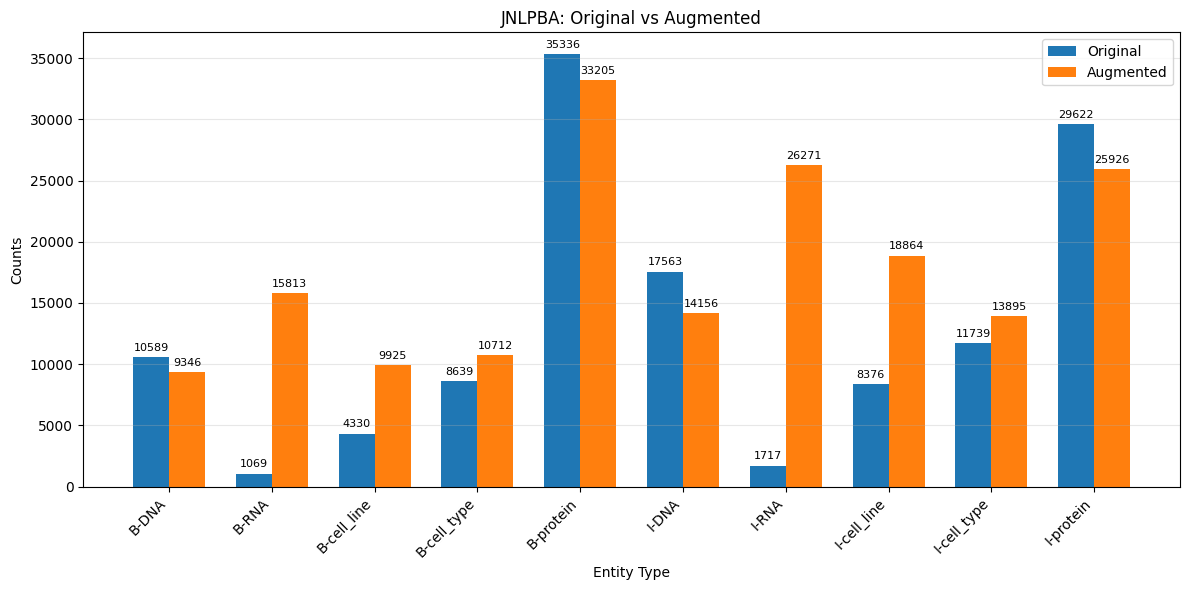

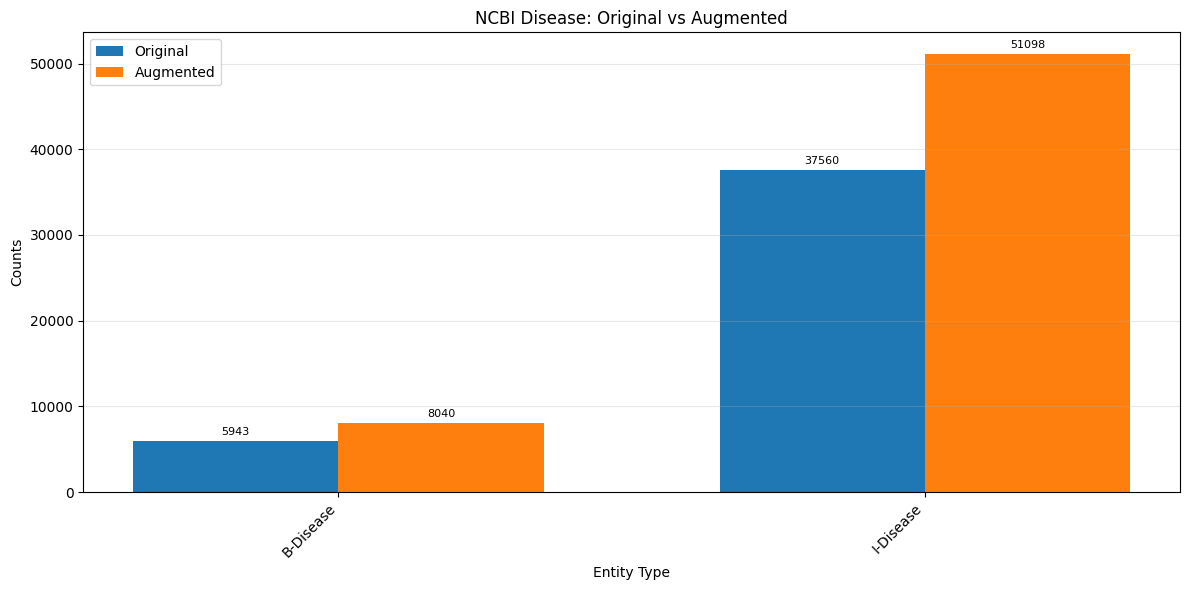


✅ FINAL CLASS DISTRIBUTIONS
JNLPBA:
  B-DNA        | Orig: 10589 → Final:  9346 ( -1243)
  B-RNA        | Orig:  1069 → Final: 15813 (+14744)
  B-cell_line  | Orig:  4330 → Final:  9925 ( +5595)
  B-cell_type  | Orig:  8639 → Final: 10712 ( +2073)
  B-protein    | Orig: 35336 → Final: 33205 ( -2131)
  I-DNA        | Orig: 17563 → Final: 14156 ( -3407)
  I-RNA        | Orig:  1717 → Final: 26271 (+24554)
  I-cell_line  | Orig:  8376 → Final: 18864 (+10488)
  I-cell_type  | Orig: 11739 → Final: 13895 ( +2156)
  I-protein    | Orig: 29622 → Final: 25926 ( -3696)

NCBI:
  B-Disease    | Orig:  5943 → Final:  8040 ( +2097)
  I-Disease    | Orig: 37560 → Final: 51098 (+13538)

Plots saved to ./plots/
Ready for training!


In [ ]:
# Valider les données sont importés :
try:
    assert len(jnlpba_sentences) > 0, "jnlpba_sentences is empty!"
    assert len(ncbi_sentences) > 0, "ncbi_sentences is empty!"
    print(f"✅ Loaded JNLPBA ({len(jnlpba_sentences)} sents) and NCBI ({len(ncbi_sentences)} sents)")
except NameError:
    raise RuntimeError("Please define jnlpba_sentences and ncbi_sentences above!")

# Entraîner FastText :
all_sentences = jnlpba_sentences + ncbi_sentences
fasttext_model = train_domain_fasttext(all_sentences, "./embedding/TrainedFastText/bio_fasttext.model")

# Balance :
jnlpba_train_aug, jnlpba_dev, jnlpba_test = split_and_balance(
    jnlpba_sentences,
    fasttext_model,
    target_ratio=0.8
)

ncbi_train_aug, ncbi_dev, ncbi_test = split_and_balance(
    ncbi_sentences,
    fasttext_model,
    target_ratio=0.8
)

print(f"\nJNLPBA train: {len(jnlpba_train_aug)} sentences")
print(f"NCBI train: {len(ncbi_train_aug)} sentences")

# Compter le nombre des entitées :
jnlpba_orig_counts = get_entity_counts(jnlpba_sentences)
jnlpba_final_counts = get_entity_counts(jnlpba_train_aug)

ncbi_orig_counts = get_entity_counts(ncbi_sentences)
ncbi_final_counts = get_entity_counts(ncbi_train_aug)

# Visualisation de la distribution :
plot_class_distribution(
    "JNLPBA: Original vs Augmented",
    jnlpba_orig_counts,
    jnlpba_final_counts,
    "./plots/jnlpba_balance.png"
)

plot_class_distribution(
    "NCBI Disease: Original vs Augmented",
    ncbi_orig_counts,
    ncbi_final_counts,
    "./plots/ncbi_balance.png"
)

# Rapport final :
print("\n" + "="*60)
print("✅ FINAL CLASS DISTRIBUTIONS")
print("="*60)
print("JNLPBA:")
for k in sorted(jnlpba_final_counts):
    orig = jnlpba_orig_counts.get(k, 0)
    final = jnlpba_final_counts[k]
    change = f"+{final - orig}" if final > orig else str(final - orig)
    print(f"  {k:12} | Orig: {orig:5} → Final: {final:5} ({change:>6})")

print("\nNCBI:")
for k in sorted(ncbi_final_counts):
    orig = ncbi_orig_counts.get(k, 0)
    final = ncbi_final_counts[k]
    change = f"+{final - orig}" if final > orig else str(final - orig)
    print(f"  {k:12} | Orig: {orig:5} → Final: {final:5} ({change:>6})")

print(f"\nPlots saved to ./plots/")
print("Ready for training!")

In [ ]:
def count_entities(dataset):
    """
    Count token-level entity labels for:
    - JNLPBA format: [(word, label), ...]
    - NCBI format: (tokens_list, labels_list)
    """
    entity_counter = Counter()
    total_sentences = 0
    total_tokens = 0

    for sent in dataset:
        # ---- Case 1: NCBI (tokens, labels)
        if isinstance(sent, (list, tuple)) and len(sent) == 2 and isinstance(sent[1], list):
            tokens, labels = sent

            if len(tokens) != len(labels):
                raise ValueError("Tokens and labels length mismatch")

            total_sentences += 1
            total_tokens += len(labels)

            for label in labels:
                if label != "O":
                    entity_counter[label] += 1

        # ---- Case 2: JNLPBA [(word, label), ...]
        elif isinstance(sent, list) and sent and isinstance(sent[0], tuple):
            total_sentences += 1
            total_tokens += len(sent)

            for _, label in sent:
                if label != "O":
                    entity_counter[label] += 1

        else:
            raise TypeError("Unknown sentence format")

    return entity_counter, total_sentences, total_tokens


#### 3. Création des datasets :

3.1. Création du dataset JNLPBA :

In [ ]:
def create_jnlpba_dataloaders(
    jnlpba_sentences,
    batch_size=32,
    max_seq_len=200,
    fastText_path=None,
    train_sentences=None,
    dev_sentences=None,
    test_sentences=None
):
    # 1. Déterminer les jeux de données à utiliser
    if train_sentences is not None and dev_sentences is not None and test_sentences is not None:
        all_sentences = train_sentences + dev_sentences + test_sentences
        print(f"Utilisation de splits fournis : "
              f"Train={len(train_sentences)}, Dev={len(dev_sentences)}, Test={len(test_sentences)}")
    else:
        # Fallback: split interne 70/15/15
        total = len(jnlpba_sentences)
        train_size = int(0.7 * total)
        dev_size = int(0.15 * total)
        train_sentences = jnlpba_sentences[:train_size]
        dev_sentences = jnlpba_sentences[train_size:train_size + dev_size]
        test_sentences = jnlpba_sentences[train_size + dev_size:]
        all_sentences = jnlpba_sentences
        print(f"Split interne JNLPBA - Train: {len(train_sentences)}, "
              f"Dev: {len(dev_sentences)}, Test: {len(test_sentences)}")

    # 2. Créer les vocabulaires sur *l'ensemble complet*
    vocab = create_vocab(all_sentences, min_freq=2)
    char_vocab = create_char_vocab(all_sentences)
    tag_to_idx, idx_to_tag = create_tag_mapping(all_sentences)

    # 3. Charger ou entraîner les embeddings FastText
    fastText_model = None
    if fastText_path and os.path.exists(fastText_path):
        print(f"Chargement du modèle d'embeddings depuis: {fastText_path}")
        fastText_model = load_fasttext_model(fastText_path)
    else:
        print("Entraînement d'un nouveau modèle d'embeddings sur le corpus complet...")
        tokenized_sentences = [
            [token.lower() for token, label in sentence]
            for sentence in all_sentences
        ]
        fastText_model = train_fasttext_embeddings(all_sentences)
        print(f"Modèle entraîné sur {len(tokenized_sentences)} phrases.")
        if fastText_path:
            try:
                save_fasttext_model(fastText_model, fastText_path)
                print(f"Modèle sauvegardé sous: {fastText_path}")
            except Exception as e:
                print(f"⚠️ Impossible de sauvegarder: {e}")

    # 4. Matrice d'embeddings
    pretrained_embeddings = create_embedding_matrix_from_fasttext(fastText_model, vocab)

    # 5. Datasets
    train_dataset = NERDataset(train_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    dev_dataset = NERDataset(dev_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    test_dataset = NERDataset(test_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)

    # 6. Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return {
        'train_loader': train_loader,
        'dev_loader': dev_loader,
        'test_loader': test_loader,
        'vocab': vocab,
        'char_vocab': char_vocab,
        'tag_to_idx': tag_to_idx,
        'idx_to_tag': idx_to_tag,
        'pretrained_embeddings': pretrained_embeddings,
        'train_sentences': train_sentences,
        'dev_sentences': dev_sentences,
        'test_sentences': test_sentences,
        'fastText_model': fastText_model
    }

In [8]:
BATCH_SIZE = 16

results_jnlpba = create_jnlpba_dataloaders(
    jnlpba_sentences,
    batch_size=BATCH_SIZE,
    fastText_path="./embeddings/fastText/jnlpba_fastText_DataAug",
    train_sentences=jnlpba_train_aug,
    dev_sentences=jnlpba_dev,
    test_sentences=jnlpba_test
)

Utilisation de splits fournis : Train=25364, Dev=3360, Test=3361
Format vocab: Liste de paires (token, label)
Vocabulaire créé: 16790 mots
Mots uniques: 22230
Mots avec fréquence >= 2: 16787
Format char vocab: Liste de paires (token, label)
Vocabulaire caractères créé: 84 caractères
Caractères uniques: 82
Format tag mapping: Liste de paires (token, label)
Mapping tags créé: 12 tags uniques
Tags: ['B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']
Entraînement d'un nouveau modèle d'embeddings sur le corpus complet...
Training FastText on 32085 sentences...
Modèle entraîné sur 32085 phrases.
FastText sauvegardé: ./embeddings/fastText/jnlpba_fastText_DataAug.model
Modèle sauvegardé sous: ./embeddings/fastText/jnlpba_fastText_DataAug
Dataset créé: 25364 phrases valides
Dataset créé: 3360 phrases valides
Dataset créé: 3361 phrases valides


In [ ]:
train_loader_jnlpba = results_jnlpba['train_loader']
dev_loader_jnlpba   = results_jnlpba['dev_loader']
test_loader_jnlpba  = results_jnlpba['test_loader']

# Récupérer un batch
for batch in train_loader_jnlpba:
    word_ids_jnlpba, char_seqs_jnlpba, tag_ids_jnlpba, lengths_jnlpba = batch
    break  # on prend juste le premier batch pour l'exemple

# Afficher les shapes
print("word_ids shape:", word_ids_jnlpba.shape)   # [batch_size, max_seq_len]
print("char_seqs shape:", char_seqs_jnlpba.shape) # [batch_size, max_seq_len, max_char_len]
print("tag_ids shape:", tag_ids_jnlpba.shape)     # [batch_size, max_seq_len]
print("lengths:", lengths_jnlpba) 

# Afficher un exemple de tokens/labels pour le premier élément du batch
idx_to_word_jnlpba = {v:k for k,v in results_jnlpba['vocab'].items()}
idx_to_tag_jnlpba = results_jnlpba['idx_to_tag']

print("\nPremier exemple du batch:")
print("Word IDs :", word_ids_jnlpba[0])
print("Char IDs :", char_seqs_jnlpba[0])
print("Tag IDs  :", tag_ids_jnlpba[0])
print("Longueur réelle:", lengths_jnlpba[0])

# Pour afficher les mots et labels décodés
decoded_words_jnlpba = [idx_to_word_jnlpba.get(w.item(), '<UNK>') for w in word_ids_jnlpba[0][:lengths_jnlpba[0]]]
decoded_tags_jnlpba  = [idx_to_tag_jnlpba[t.item()] for t in tag_ids_jnlpba[0][:lengths_jnlpba[0]]]

print("\nDécodé (mots, tags) :", list(zip(decoded_words_jnlpba, decoded_tags_jnlpba))) 

word_ids shape: torch.Size([16, 200])
char_seqs shape: torch.Size([16, 200, 20])
tag_ids shape: torch.Size([16, 200])
lengths: tensor([43, 29, 31, 17, 39, 45, 11, 30, 28, 23, 25, 24, 24, 18, 14, 27])

Premier exemple du batch:
Word IDs : tensor([  250, 12856,   700,    76,  2001,   265,   118,   225,    97, 11924,
           72,  2913, 11166,    96,     8,    63,   711,  1197,   259,   495,
            5,   289,  8417,     5,   281, 12903,   561, 13013,  1186,   406,
         6864, 10539, 12381,  2643,  2001,    15,   700,   132,     5, 12858,
         8580,  1501,    28,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    

3.2. Création du dataset NCBI :

In [ ]:
def create_ncbi_dataloaders(
    ncbi_sentences,
    batch_size=32,
    max_seq_len=200,
    fastText_path=None,
    train_sentences=None,
    dev_sentences=None,
    test_sentences=None 
):
    
    # 1. Créer les vocabulaires sur l'ensemble complet
    if train_sentences is not None and dev_sentences is not None and test_sentences is not None:
        all_sentences = train_sentences + dev_sentences + test_sentences
        print(f"Utilisation de splits fournis : "
              f"Train={len(train_sentences)}, Dev={len(dev_sentences)}, Test={len(test_sentences)}")
    else:
        # Fallback au split interne
        total = len(ncbi_sentences)
        train_size = int(0.7 * total)
        dev_size = int(0.15 * total)
        train_sentences = ncbi_sentences[:train_size]
        dev_sentences = ncbi_sentences[train_size:train_size + dev_size]
        test_sentences = ncbi_sentences[train_size + dev_size:]
        all_sentences = ncbi_sentences
        print(f"Split interne NCBI - Train: {len(train_sentences)}, "
              f"Dev: {len(dev_sentences)}, Test: {len(test_sentences)}")

    vocab = create_vocab(all_sentences, min_freq=2)
    char_vocab = create_char_vocab(all_sentences)
    tag_to_idx, idx_to_tag = create_tag_mapping(all_sentences)

    # 2. Charger ou entraîner les embeddings sur toutes les données
    fastText_model = None
    if fastText_path and os.path.exists(fastText_path):
        print(f"Chargement du modèle d'embeddings depuis: {fastText_path}")
        fastText_model = load_fasttext_model(fastText_path)
    else:
        print("Entraînement d'un nouveau modèle d'embeddings (FastText/fastText) sur le corpus complet...")
        fastText_model = train_fasttext_embeddings(all_sentences)
        if fastText_path:
            try:
                save_fasttext_model(fastText_model, fastText_path)
                print(f"Modèle sauvegardé sous: {fastText_path}")
            except Exception as e:
                print(f"⚠️ Impossible de sauvegarder le modèle: {e}")

    # 3. Créer la matrice d'embeddings
    pretrained_embeddings = create_embedding_matrix_from_fasttext(fastText_model, vocab)

    # 4. Créer les datasets
    train_dataset = NERDataset(train_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    dev_dataset = NERDataset(dev_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)
    test_dataset = NERDataset(test_sentences, vocab, char_vocab, tag_to_idx, max_seq_len=max_seq_len)

    # 5. Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return {
        'train_loader': train_loader,
        'dev_loader': dev_loader,
        'test_loader': test_loader,
        'vocab': vocab,
        'char_vocab': char_vocab,
        'tag_to_idx': tag_to_idx,
        'idx_to_tag': idx_to_tag,
        'pretrained_embeddings': pretrained_embeddings,
        'train_sentences': train_sentences,
        'dev_sentences': dev_sentences,
        'test_sentences': test_sentences,
        'fastText_model': fastText_model
    }

In [11]:
BATCH_SIZE= 16

results_ncbi = create_ncbi_dataloaders(
    ncbi_sentences=ncbi_sentences,
    train_sentences=ncbi_train_aug,
    dev_sentences=ncbi_dev,
    test_sentences=ncbi_test,
    batch_size=BATCH_SIZE,
    fastText_path="./embeddings/fastText/ncbi_fastText_DataAug"
)

Utilisation de splits fournis : Train=1110, Dev=118, Test=120
Format vocab: Tuple (tokens, labels)
Vocabulaire créé: 9612 mots
Mots uniques: 12039
Mots avec fréquence >= 2: 9609
Format char vocab: Tuple (tokens, labels)
Vocabulaire caractères créé: 86 caractères
Caractères uniques: 84
Format tag mapping: Tuple (tokens, labels)
Mapping tags créé: 4 tags uniques
Tags: ['B-Disease', 'I-Disease', 'O']
Entraînement d'un nouveau modèle d'embeddings (FastText/fastText) sur le corpus complet...
Training FastText on 1348 sentences...
FastText sauvegardé: ./embeddings/fastText/ncbi_fastText_DataAug.model
Modèle sauvegardé sous: ./embeddings/fastText/ncbi_fastText_DataAug
Dataset créé: 1110 phrases valides
Dataset créé: 118 phrases valides
Dataset créé: 120 phrases valides


In [ ]:
train_loader_ncbi = results_ncbi['train_loader']

# Récupérer un batch
for batch in train_loader_ncbi:
    word_ids_ncbi, char_seqs_ncbi, tag_ids_ncbi, lengths_ncbi = batch
    break  # on prend juste le premier batch pour l'exemple

# Afficher les shapes
print("word_ids shape:", word_ids_ncbi.shape)   # [batch_size, max_seq_len]
print("char_seqs shape:", char_seqs_ncbi.shape) # [batch_size, max_seq_len, max_char_len]
print("tag_ids shape:", tag_ids_ncbi.shape)     # [batch_size, max_seq_len]
print("lengths:", lengths_ncbi) 

# Afficher un exemple de tokens/labels pour le premier élément du batch
idx_to_word_ncbi = {v:k for k,v in results_ncbi['vocab'].items()}
idx_to_tag_ncbi = results_ncbi['idx_to_tag']

print("\nPremier exemple du batch:")
print("Word IDs :", word_ids_ncbi[0])
print("Char IDs :", char_seqs_ncbi[0])
print("Tag IDs  :", tag_ids_ncbi[0])
print("Longueur réelle:", lengths_ncbi[0])

# Pour afficher les mots et labels décodés
decoded_words_ncbi = [idx_to_word_ncbi.get(w.item(), '<UNK>') for w in word_ids_ncbi[0][:lengths_ncbi[0]]]
decoded_tags_ncbi  = [idx_to_tag_ncbi[t.item()] for t in tag_ids_ncbi[0][:lengths_ncbi[0]]]

print("\nDécodé (mots, tags) :", list(zip(decoded_words_ncbi, decoded_tags_ncbi))) 

word_ids shape: torch.Size([16, 200])
char_seqs shape: torch.Size([16, 200, 20])
tag_ids shape: torch.Size([16, 200])
lengths: tensor([188, 200, 200, 200, 200, 152, 168, 200, 103,  74, 200, 200, 188, 181,
        200, 200])

Premier exemple du batch:
Word IDs : tensor([5653, 2910, 6479,  318,  230,   17,   26, 3481,   30,   25,   26, 1223,
          17,  905, 2039,  231, 2307,   23,    1,  505, 7276,  930,   17,   26,
         674,   95,   34,   96,  108,   76, 7906,   26, 3481,   30,  150,  327,
        2029, 2030,  339, 7886, 2031,    7, 7959,  409,  110, 9075,    5, 1498,
        7886, 2515, 7889, 8061, 6264,  521,  103,  428,   25,    1,  821, 2442,
        7906, 1080,  114, 7277, 2039,  231, 2307,   41,   25,    1,  821, 2442,
          17, 7278, 2039,  231, 2307,   31,   25,    1,   17,   26,    1, 1080,
         114, 7277, 2039,  231, 2307,   23, 3762, 4143,  303, 2114,  412,  428,
         150, 7444,   41, 6861, 8092, 1498, 8512,   31,  349, 7965, 1963,  103,
        2586, 7946

3.3. Analyse du dataset :

In [13]:
# Get entity counts
entities_jnlpba, n_sent_jnlpba, n_tok_jnlpba = count_entities(
    results_jnlpba["train_sentences"]
)

entities_ncbi, n_sent_ncbi, n_tok_ncbi = count_entities(
    results_ncbi["train_sentences"]
)

In [14]:
print("\n📊 After augmentation:")
post_counts_jnlpba = get_entity_counts(jnlpba_train_aug)
post_counts_ncbi   = get_entity_counts(ncbi_train_aug)
print("JNLPBA train (post-aug):", dict(post_counts_jnlpba))
print("NCBI   train (post-aug):", dict(post_counts_ncbi))


📊 After augmentation:
JNLPBA train (post-aug): {'B-cell_line': 9925, 'I-cell_line': 18864, 'B-protein': 33205, 'B-DNA': 9346, 'I-DNA': 14156, 'I-protein': 25926, 'B-cell_type': 10712, 'I-cell_type': 13895, 'B-RNA': 15813, 'I-RNA': 26271}
NCBI   train (post-aug): {'B-Disease': 8040, 'I-Disease': 51098}


In [15]:
import pickle
with open("./datasets/augmented_jnlpba_train.pkl", "wb") as f:
    pickle.dump(jnlpba_train_aug, f)
with open("./datasets/augmented_ncbi_train.pkl", "wb") as f:
    pickle.dump(ncbi_train_aug, f)

3.4. Visualiser les districution des données

In [ ]:
def preview_first_sentence(results, dataset_name="DATASET"):
    """
    Affichage de la première phrase de chaque split : train/dev/test.
    Prend en condération les tuples, lsite des tuples ou les dicts pour mieux traiter les différences entre datasets.
    """
    print("=" * 60)
    print(f"PREVIEW DATASET: {dataset_name}")
    print("=" * 60)

    split_aliases = {
        "train": ["train_sentences", "train", "train_loader"],
        "dev": ["dev_sentences", "devel_sentences", "dev", "devel", "valid", "validation", "dev_loader"],
        "test": ["test_sentences", "test", "test_loader"]
    }

    for split_name, aliases in split_aliases.items():
        key = next((k for k in aliases if k in results), None)
        if key is None:
            continue

        data = results[key]

        # Extraction du premier batch si le dataloader existe
        if "loader" in key:
            batch = next(iter(data))
            if isinstance(batch, (list, tuple)):
                first_sent = batch[0]
            else:
                first_sent = batch
        else:
            first_sent = data[0]

        
        # Extraction des tokens et labels en se basant sur leur type
        if isinstance(first_sent, tuple) and len(first_sent) == 2:
            tokens, labels = first_sent
        elif isinstance(first_sent, list) and first_sent and isinstance(first_sent[0], tuple):
            tokens, labels = zip(*first_sent)
        elif isinstance(first_sent, dict) and "tokens" in first_sent and "labels" in first_sent:
            tokens = first_sent["tokens"]
            labels = first_sent["labels"]
        else:
            tokens, labels = [], []

        print(f"\n--- {split_name.upper()} ---")
        print(f"Tokens : {tokens}")
        print(f"Labels : {labels}")

    print("=" * 60)


# Affichages de quelques phrases après le split :
preview_first_sentence({
    "train_sentences": jnlpba_sentences,
    "dev_sentences": jnlpba_sentences,
    "test_sentences": jnlpba_sentences
}, dataset_name="JNLPBA")

preview_first_sentence({
    "train_sentences": ncbi_sentences[:100], 
    "test_sentences": ncbi_sentences[120:140]
}, dataset_name="NCBI")


PREVIEW DATASET: JNLPBA

--- TRAIN ---
Tokens : ('IL-2', 'gene', 'expression', 'and', 'NF-kappa', 'B', 'activation', 'through', 'CD28', 'requires', 'reactive', 'oxygen', 'production', 'by', '5-lipoxygenase', '.')
Labels : ('B-DNA', 'I-DNA', 'O', 'O', 'B-protein', 'I-protein', 'O', 'O', 'B-protein', 'O', 'O', 'O', 'O', 'O', 'B-protein', 'O')

--- DEV ---
Tokens : ('IL-2', 'gene', 'expression', 'and', 'NF-kappa', 'B', 'activation', 'through', 'CD28', 'requires', 'reactive', 'oxygen', 'production', 'by', '5-lipoxygenase', '.')
Labels : ('B-DNA', 'I-DNA', 'O', 'O', 'B-protein', 'I-protein', 'O', 'O', 'B-protein', 'O', 'O', 'O', 'O', 'O', 'B-protein', 'O')

--- TEST ---
Tokens : ('IL-2', 'gene', 'expression', 'and', 'NF-kappa', 'B', 'activation', 'through', 'CD28', 'requires', 'reactive', 'oxygen', 'production', 'by', '5-lipoxygenase', '.')
Labels : ('B-DNA', 'I-DNA', 'O', 'O', 'B-protein', 'I-protein', 'O', 'O', 'B-protein', 'O', 'O', 'O', 'O', 'O', 'B-protein', 'O')
PREVIEW DATASET: NCBI


In [17]:
train_sentences = results_ncbi["train_sentences"]

tokens = 0
entities = 0

for sentence in train_sentences:
    tokens += len(sentence)
    entities += sum(1 for item in sentence if item[1] != "O")


print("TRAIN")
print(f"  sentences: {len(train_sentences)}")
print(f"  tokens: {tokens}")
print(f"  entities: {entities}")

TRAIN
  sentences: 1110
  tokens: 2220
  entities: 1506


ANALYSE DU DATASET: JNLPBA

1. RÉPARTITION DES DONNÉES
----------------------------------------

TRAIN:
  Phrases: 25,364
  Tokens: 732,536
  Entités nommées: 178,113
  Densité d'entités: 24.3%

DEV:
  Phrases: 3,360
  Tokens: 90,055
  Entités nommées: 19,762
  Densité d'entités: 21.9%

TEST:
  Phrases: 3,361
  Tokens: 88,214
  Entités nommées: 19,175
  Densité d'entités: 21.7%

2. LONGUEUR DES PHRASES
----------------------------------------

TRAIN:
  Moyenne: 28.9 tokens
  Médiane: 27.0 tokens
  Min-Max: 2-208 tokens
  >100 tokens: 58

DEV:
  Moyenne: 26.8 tokens
  Médiane: 25.0 tokens
  Min-Max: 2-150 tokens
  >100 tokens: 2

TEST:
  Moyenne: 26.2 tokens
  Médiane: 24.0 tokens
  Min-Max: 2-123 tokens
  >100 tokens: 3


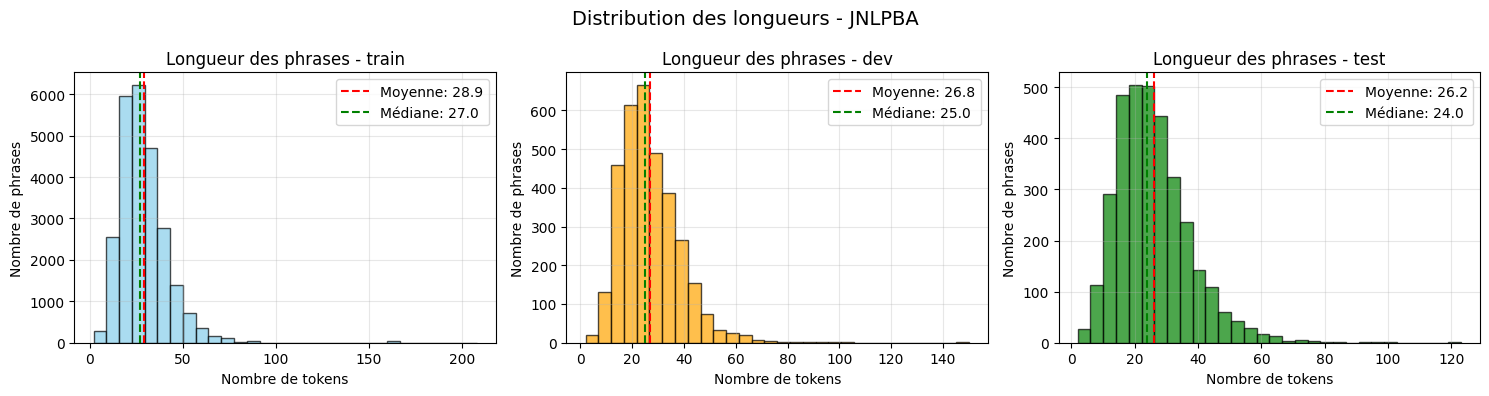


3. DISTRIBUTION DES CLASSES D'ENTITÉS
----------------------------------------

Fréquences absolues:
Classe                    TRAIN        DEV       TEST
-----------------------------------------------------
O                       554,423     70,293     69,039
B-DNA                     9,346      1,642      1,623
B-RNA                    15,813        158        158
B-cell_line               9,925        645        689
B-cell_type              10,712      1,331      1,285
B-protein                33,205      5,369      5,134
I-DNA                    14,156      2,723      2,689
I-RNA                    26,271        247        219
I-cell_line              18,864      1,279      1,237
I-cell_type              13,895      1,775      1,806
I-protein                25,926      4,593      4,335

Pourcentages (par split):
Classe                    TRAIN        DEV       TEST
-----------------------------------------------------
O                         75.7%      78.1%      78.3%
B-DNA  

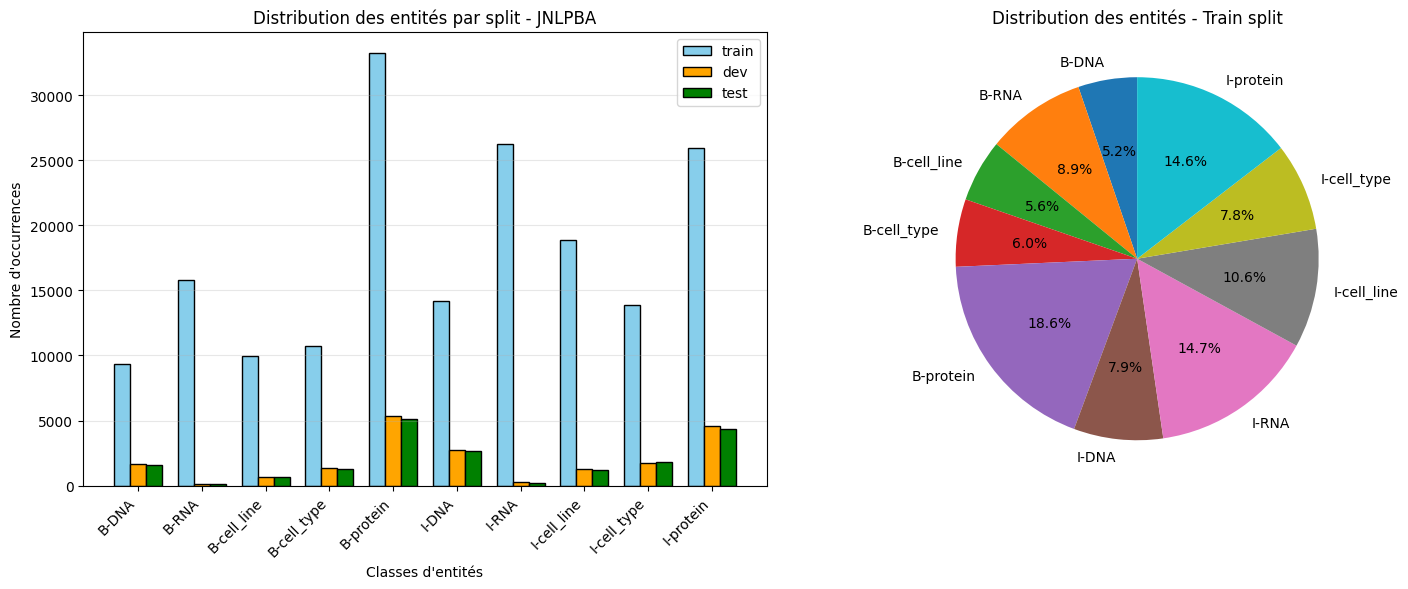


5. ENTITÉS PAR PHRASE
----------------------------------------

TRAIN:
  Entités/phrase (moyenne): 7.02
  Entités/phrase (médiane): 6.0
  Phrases sans entité: 1,772 (7.0%)

DEV:
  Entités/phrase (moyenne): 5.88
  Entités/phrase (médiane): 5.0
  Phrases sans entité: 373 (11.1%)

TEST:
  Entités/phrase (moyenne): 5.71
  Entités/phrase (médiane): 5.0
  Phrases sans entité: 391 (11.6%)


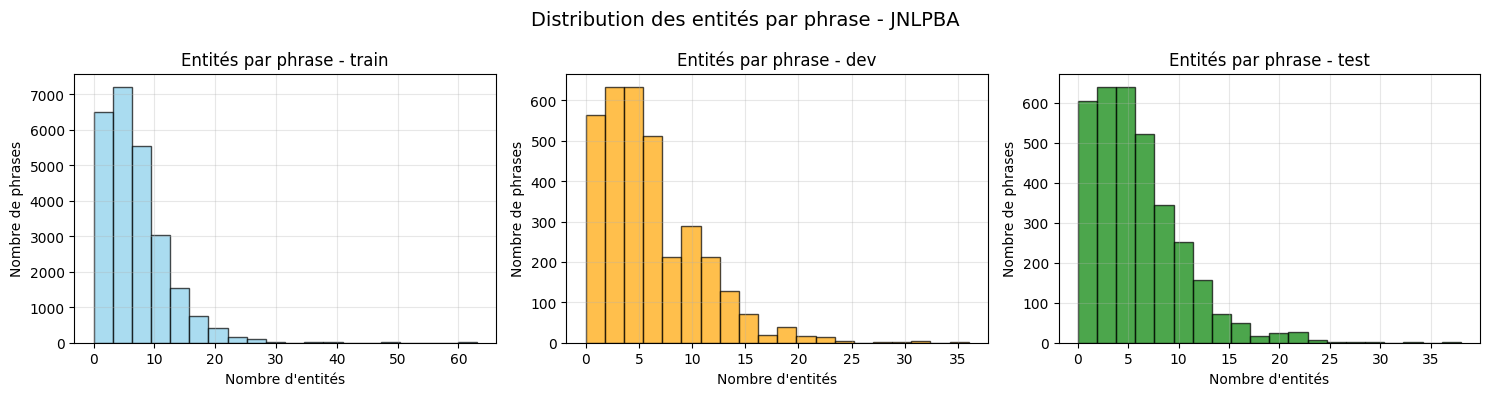


6. ANALYSE DES TAGS BIO
----------------------------------------
Total des tags: 910,805
  B: 97,035 (10.7%)
  I: 120,015 (13.2%)
  O: 693,755 (76.2%)
  autres: 0 (0.0%)

7. INFORMATIONS SUPPLÉMENTAIRES
----------------------------------------
Taille du vocabulaire: 16,790 mots
Taille du vocabulaire caractères: 84
Nombre de classes uniques: 12
Classes: ['<PAD>', 'B-DNA', 'B-RNA', 'B-cell_line', 'B-cell_type', 'B-protein', 'I-DNA', 'I-RNA', 'I-cell_line', 'I-cell_type', 'I-protein', 'O']

ANALYSE TERMINÉE


In [18]:
visualize_dataset_distribution(results_jnlpba, dataset_name="JNLPBA")

ANALYSE DU DATASET: NCBI

1. RÉPARTITION DES DONNÉES
----------------------------------------
Format détecté: NCBI

TRAIN:
  Phrases: 1,110
  Tokens: 239,234
  Entités nommées: 59,138
  Densité d'entités: 24.7%

DEV:
  Phrases: 118
  Tokens: 24,662
  Entités nommées: 6,916
  Densité d'entités: 28.0%

TEST:
  Phrases: 120
  Tokens: 25,768
  Entités nommées: 7,018
  Densité d'entités: 27.2%

2. LONGUEUR DES PHRASES
----------------------------------------

TRAIN:
  Moyenne: 215.5 tokens
  Médiane: 213.0 tokens
  Min-Max: 36-514 tokens
  >100 tokens: 1,060

DEV:
  Moyenne: 209.0 tokens
  Médiane: 188.5 tokens
  Min-Max: 45-512 tokens
  >100 tokens: 113

TEST:
  Moyenne: 214.7 tokens
  Médiane: 215.5 tokens
  Min-Max: 79-440 tokens
  >100 tokens: 111


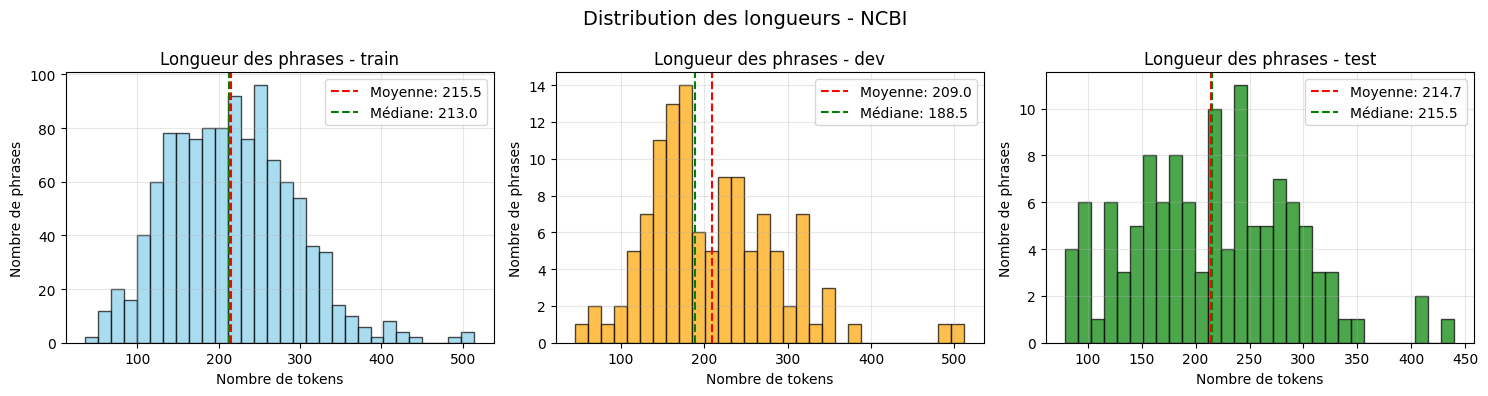


3. DISTRIBUTION DES CLASSES D'ENTITÉS
----------------------------------------

Fréquences absolues:
Classe                    TRAIN        DEV       TEST
-----------------------------------------------------
O                       180,096     17,746     18,750
B-Disease                 8,040        954        969
I-Disease                51,098      5,962      6,049

Pourcentages (par split):
Classe                    TRAIN        DEV       TEST
-----------------------------------------------------
O                         75.3%      72.0%      72.8%
B-Disease                  3.4%       3.9%       3.8%
I-Disease                 21.4%      24.2%      23.5%

4. VISUALISATION DES ENTITÉS (sans 'O')


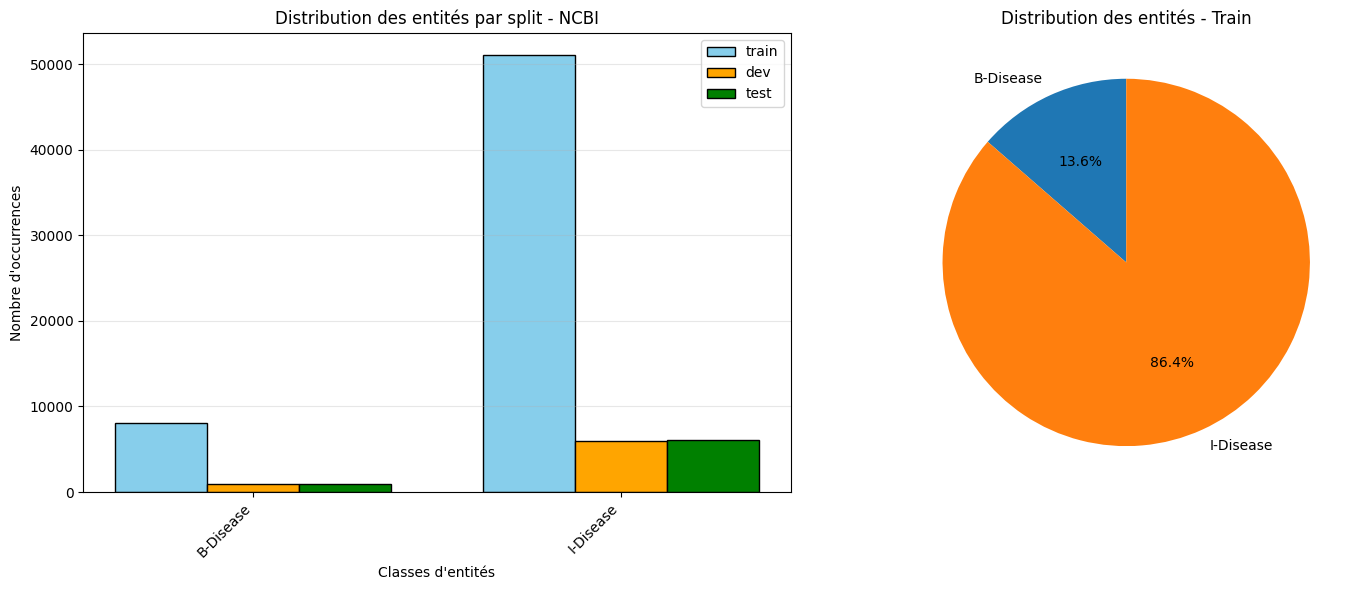


5. ENTITÉS PAR PHRASE
----------------------------------------

TRAIN:
  Entités/phrase (moy): 53.28
  Entités/phrase (méd): 46.0
  Phrases sans entité: 0 (0.0%)

DEV:
  Entités/phrase (moy): 58.61
  Entités/phrase (méd): 50.0
  Phrases sans entité: 1 (0.8%)

TEST:
  Entités/phrase (moy): 58.48
  Entités/phrase (méd): 51.0
  Phrases sans entité: 0 (0.0%)


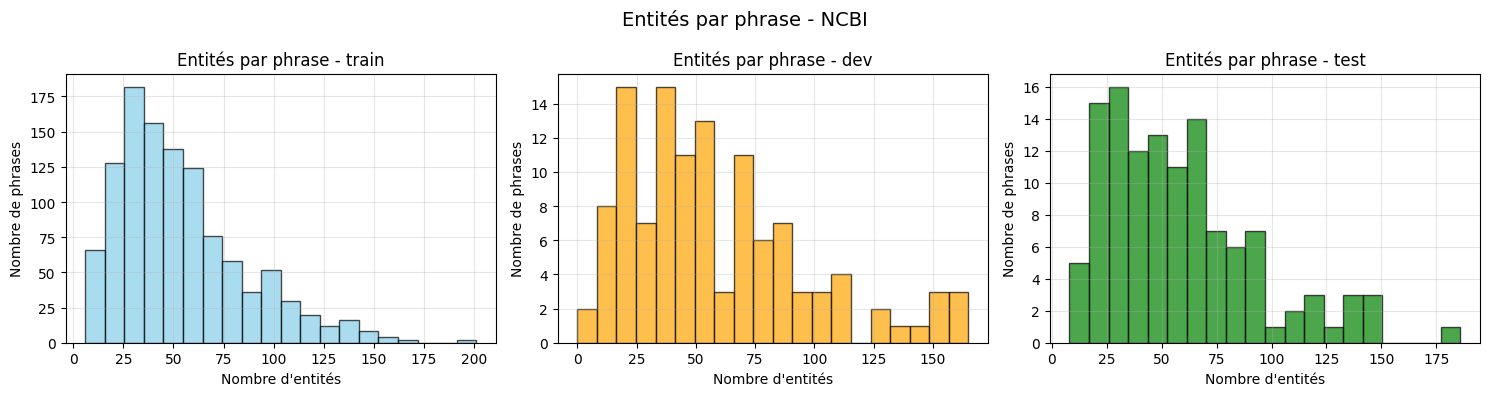


6. ANALYSE DES TAGS BIO
----------------------------------------
Total des tags: 289,664
  B: 9,963 (3.4%)
  I: 63,109 (21.8%)
  O: 216,592 (74.8%)
  autres: 0 (0.0%)

7. INFORMATIONS SUPPLÉMENTAIRES
----------------------------------------
Vocabulaire: 9,612 mots
Classes: ['<PAD>', 'B-Disease', 'I-Disease', 'O']

ANALYSE TERMINÉE


In [19]:
visualize_dataset_distribution_ncbi(results_ncbi, dataset_name="NCBI")

## ÉTAPE 3: Architecture du Model 

In [ ]:
from tqdm import tqdm
def train_epoch(model, dataloader, optimizer, device):
    """
    Entraînement pour une epoch avec CRF
    """
    model.train()
    total_loss = 0.0

    for batch in tqdm(dataloader,total=len(dataloader),desc="Training"):
        word_ids, char_seqs, tag_ids, lengths = batch

        word_ids = word_ids.to(device)
        char_seqs = char_seqs.to(device)
        tag_ids = tag_ids.to(device)

        mask = (word_ids != 0)
        optimizer.zero_grad()
        # Passer les tags à forward retourne la loss directement
        loss = model(word_ids, char_seqs, mask, tag_ids)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


def evaluate(model, dataloader, device, idx_to_tag):
    """
    Evaluaer le modèle (CRF)
    """
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch in dataloader:
            word_ids, char_seqs, tag_ids, lengths = batch

            word_ids = word_ids.to(device)
            char_seqs = char_seqs.to(device)
            tag_ids = tag_ids.to(device)

            mask = (word_ids != 0)

            # Calculer la loss
            loss = model(word_ids, char_seqs, mask, tag_ids)
            total_loss += loss.item()

            # Décoder les séquences pour obtenir les prédictions
            predictions = model(word_ids, char_seqs, mask, tags=None)  # renvoie une list
            # Stocker les prédictions et targets
            for preds_seq, tag_seq, seq_len in zip(predictions, tag_ids, lengths):
                preds_seq = preds_seq[:seq_len]          # découper au vrai length
                tag_seq = tag_seq[:seq_len].cpu().numpy()  # tag_ids tensor => numpy

                pred_tags = [idx_to_tag.get(idx, 'O') for idx in preds_seq]
                target_tags = [idx_to_tag.get(idx, 'O') for idx in tag_seq]

                all_predictions.extend(pred_tags)
                all_targets.extend(target_tags)

    return total_loss / len(dataloader), all_predictions, all_targets



def calculate_metrics(predictions, targets):
    """
    Calculer la précision, rappek et F1-score
    """
    from sklearn.metrics import precision_recall_fscore_support
    
    # Filtrer les tags 'O' pour une évaluation spécifique aux entités
    entity_preds = []
    entity_targets = []
    
    for pred, target in zip(predictions, targets):
        if target != 'O' or pred != 'O':
            entity_preds.append(pred)
            entity_targets.append(target)
    
    precision, recall, f1, _ = precision_recall_fscore_support(
        entity_targets, entity_preds, average='macro', zero_division=0
    )
    
    return precision, recall, f1


In [21]:
def load_trained_model(model_path, dataset_name, loaders_dict,use_char_cnn=False,use_char_lstm=False,use_attention=False,use_fc_fusion=False):
    """
    Charge un modèle entraîné et le prépare pour les prédictions
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Récupérer les paramètres du loader
    vocab = loaders_dict['vocab']
    char_vocab = loaders_dict['char_vocab']
    tag_to_idx = loaders_dict['tag_to_idx']
    idx_to_tag = loaders_dict['idx_to_tag']
    
    # Déterminer les paramètres selon le dataset
    if dataset_name == 'JNLPBA':
        lstm_hidden = 256
    else:  # NCBI-Disease
        lstm_hidden = 128
    
    # Créer le modèle
    model = CombinatorialNER(
        dataset=dataset_name,
        vocab_size=len(vocab),
        char_vocab_size=len(char_vocab),
        tag_to_idx=tag_to_idx,
        use_char_cnn=use_char_cnn,       
        use_char_lstm=use_char_lstm,      
        use_attention=use_attention,     
        use_fc_fusion=use_fc_fusion,  
        pretrained_embeddings=None,  
        word_embed_dim=200,
        lstm_hidden_dim=lstm_hidden,
        dropout=0.5
    ).to(device)

    
    # Charger les poids sauvegardés
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Mode évaluation
    
    print(f"Modèle chargé depuis: {model_path}")
    print(f"Best F1 enregistré: {checkpoint.get('best_f1', 'N/A'):.4f}")
    print(f"Époque: {checkpoint.get('epoch', 'N/A')}")
    
    return model, device, idx_to_tag

def plot_confusion_matrix_by_class(
    predictions, 
    targets, 
    idx_to_tag, 
    dataset_name="Dataset",
    figsize=(14, 6)
):
    """
    Affiche DEUX matrices de confusion + rapports complets :
    • Haut : TOUS les tokens (incluant 'O')
    • Bas  : ENTITÉS SEULEMENT (excluant 'O')
    
    Returns:
        dict: {
            'with_O': {'accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'f1_weighted'},
            'without_O': {same},
            'per_class_with_O': {...},
            'per_class_without_O': {...}
        }
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import (
        confusion_matrix, classification_report, 
        precision_recall_fscore_support, accuracy_score
    )

    # --- Preprocess ---
    predictions = [str(p) for p in predictions]
    targets = [str(t) for t in targets]

    # Get all unique labels (sorted)
    all_labels = sorted(set(targets + predictions))
    entity_labels = [l for l in all_labels if l != 'O']

    print(f"\n📊 ÉVALUATION NER — {dataset_name}")
    print("=" * 60)
    print(f"✓ Tokens totaux         : {len(targets):,}")
    print(f"✓ Tokens entités (non-O): {len([t for t in targets if t != 'O']):,}")

    results = {}

    # ==============================
    # 1. WITH 'O' (all tokens)
    # ==============================
    print("\n" + "─" * 50)
    print("✅ ÉVALUATION AVEC 'O' (tous les tokens)")
    print("─" * 50)

    acc_all = accuracy_score(targets, predictions)
    precision_macro_all, recall_macro_all, f1_macro_all, _ = precision_recall_fscore_support(
        targets, predictions, average='macro', zero_division=0
    )
    precision_weighted_all, recall_weighted_all, f1_weighted_all, _ = precision_recall_fscore_support(
        targets, predictions, average='weighted', zero_division=0
    )

    print(f"  Accuracy (tous tokens)    : {acc_all:.4f}")
    print(f"  F1 Macro                 : {f1_macro_all:.4f}")
    print(f"  F1 Weighted              : {f1_weighted_all:.4f}")

    # Confusion matrix (with 'O')
    cm_all = confusion_matrix(targets, predictions, labels=all_labels)
    cm_norm_all = cm_all.astype('float') / cm_all.sum(axis=1, keepdims=True)
    cm_norm_all = np.nan_to_num(cm_norm_all)

    # Classification report
    report_all = classification_report(targets, predictions, zero_division=0, output_dict=True)
    per_class_with_O = {
        label: {
            'precision': report_all[label]['precision'],
            'recall': report_all[label]['recall'],
            'f1': report_all[label]['f1-score'],
            'support': int(report_all[label]['support'])
        }
        for label in all_labels if label in report_all and 'support' in report_all[label]
    }

    results['with_O'] = {
        'accuracy': acc_all,
        'precision_macro': precision_macro_all,
        'recall_macro': recall_macro_all,
        'f1_macro': f1_macro_all,
        'f1_weighted': f1_weighted_all
    }
    results['per_class_with_O'] = per_class_with_O

    # ==============================
    # 2. WITHOUT 'O' (entities only)
    # ==============================
    print("\n" + "─" * 50)
    print("✅ ÉVALUATION SANS 'O' (entités uniquement)")
    print("─" * 50)

    entity_mask = [t != 'O' for t in targets]
    entity_preds = [p for p, m in zip(predictions, entity_mask) if m]
    entity_targets = [t for t, m in zip(targets, entity_mask) if m]

    if entity_targets:
        acc_entities = accuracy_score(entity_targets, entity_preds)
        precision_macro_ent, recall_macro_ent, f1_macro_ent, _ = precision_recall_fscore_support(
            entity_targets, entity_preds, average='macro', zero_division=0
        )
        precision_weighted_ent, recall_weighted_ent, f1_weighted_ent, _ = precision_recall_fscore_support(
            entity_targets, entity_preds, average='weighted', zero_division=0
        )

        print(f"  Accuracy (tokens entités) : {acc_entities:.4f}")
        print(f"  F1 Macro                  : {f1_macro_ent:.4f}")
        print(f"  F1 Weighted               : {f1_weighted_ent:.4f}")
    else:
        acc_entities = precision_macro_ent = recall_macro_ent = f1_macro_ent = f1_weighted_ent = 0.0
        print("  ⚠️ Aucune entité trouvée.")

    # Confusion matrix (without 'O')
    cm_ent = confusion_matrix(entity_targets, entity_preds, labels=entity_labels) if entity_labels else np.array([[0]])
    cm_norm_ent = cm_ent.astype('float') / cm_ent.sum(axis=1, keepdims=True) if cm_ent.size else cm_ent
    cm_norm_ent = np.nan_to_num(cm_norm_ent)

    # Classification report (entities only)
    per_class_without_O = {}
    if entity_labels and entity_targets:
        report_ent = classification_report(entity_targets, entity_preds, labels=entity_labels, zero_division=0, output_dict=True)
        per_class_without_O = {
            label: {
                'precision': report_ent[label]['precision'],
                'recall': report_ent[label]['recall'],
                'f1': report_ent[label]['f1-score'],
                'support': int(report_ent[label]['support'])
            }
            for label in entity_labels if label in report_ent and 'support' in report_ent[label]
        }

    results['without_O'] = {
        'accuracy': acc_entities,
        'precision_macro': precision_macro_ent,
        'recall_macro': recall_macro_ent,
        'f1_macro': f1_macro_ent,
        'f1_weighted': f1_weighted_ent
    }
    results['per_class_without_O'] = per_class_without_O

    # ==============================
    # 3. PLOTS (Side-by-side)
    # ==============================
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # --- Left: WITH 'O' ---
    sns.heatmap(
        cm_norm_all, annot=True, fmt='.2f', cmap='Blues',
        xticklabels=all_labels, yticklabels=all_labels,
        ax=axes[0], cbar_kws={'label': 'Proportion'}
    )
    axes[0].set_title(f"Tous les tokens (incluant 'O')\nAcc: {acc_all:.3f} | F1 (macro): {f1_macro_all:.3f}")
    axes[0].set_xlabel('Prédictions')
    axes[0].set_ylabel('Vérité')

    # --- Right: WITHOUT 'O' ---
    if entity_labels:
        sns.heatmap(
            cm_norm_ent, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=entity_labels, yticklabels=entity_labels,
            ax=axes[1], cbar_kws={'label': 'Proportion'}
        )
        axes[1].set_title(f"Entités uniquement (sans 'O')\nAcc: {acc_entities:.3f} | F1 (macro): {f1_macro_ent:.3f}")
        axes[1].set_xlabel('Prédictions')
        axes[1].set_ylabel('Vérité')
    else:
        axes[1].text(0.5, 0.5, 'Aucune entité', ha='center', va='center', fontsize=14)
        axes[1].set_title("Entités uniquement (sans 'O')")

    plt.suptitle(f"Matrices de confusion — {dataset_name}", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # ==============================
    # 4. Per-class tables
    # ==============================
    def print_per_class_table(metrics_dict, title):
        if not metrics_dict:
            print(f"\n{title}\n" + "─" * 50 + "\n⚠️ Aucune classe à afficher")
            return
        print(f"\n{title}")
        print("─" * 60)
        print(f"{'Classe':<20} {'Précision':<10} {'Rappel':<10} {'F1':<10} {'Support':<8}")
        print("─" * 60)
        for label, m in sorted(metrics_dict.items()):
            print(f"{label:<20} {m['precision']:<10.4f} {m['recall']:<10.4f} {m['f1']:<10.4f} {m['support']:<8}")

    print_per_class_table(per_class_with_O, "📊 Métriques par classe (AVEC 'O')")
    print_per_class_table(per_class_without_O, "📊 Métriques par classe (SANS 'O')")

    return results

def predict_on_test_set(model, test_loader, device, idx_to_tag):
    """
    Version simplifiée et robuste
    """
    shown_example = False
    model.eval()
    all_predictions = []
    all_targets = []
    for idx, tag in sorted(idx_to_tag.items()):
        print(f"  {idx} -> {tag}")
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            word_ids, char_seqs, tag_ids, lengths = batch
            
            word_ids = word_ids.to(device)
            char_seqs = char_seqs.to(device)
            tag_ids = tag_ids.to(device)
            mask = (word_ids != 0)
            pred_sequences = model(word_ids, char_seqs, mask, tags=None)
            
            for i in range(len(word_ids)):
                actual_len = lengths[i]
                if isinstance(pred_sequences, list):
                    pred_seq = pred_sequences[i][:actual_len]
                else:
                    pred_seq = torch.argmax(pred_sequences[i], dim=1)[:actual_len].cpu().numpy()
                
                # Convertir indices -> tags
                pred_tags = []
                for idx in pred_seq:
                    if isinstance(idx, torch.Tensor):
                        idx = idx.item()
                    tag = idx_to_tag.get(int(idx), 'O')
                    pred_tags.append(tag)
                
                # Convertir cibles indices -> tags
                target_indices = tag_ids[i][:actual_len].cpu().numpy()
                target_tags = [idx_to_tag.get(int(idx), 'O') for idx in target_indices]
                
                all_predictions.extend(pred_tags)
                all_targets.extend(target_tags)
                if not shown_example:
                    for pos, (g, p) in enumerate(zip(target_tags, pred_tags)):
                            mark = "correct" if g == p else "incorrect"
                            print(f"{pos:3d} | {g:18s} | {p:18s} {mark}")
                    shown_example=True
    
    return all_predictions, all_targets  


In [22]:
def run_pipeline(
    dataset_name: str,
    loaders: dict,
    use_char_cnn: bool = False,
    use_char_lstm: bool = False,
    use_attention: bool = False,
    use_fc_fusion: bool = False,
    embedding_url: str = None,
    lstm_hidden_dim: Optional[int] = None,
    epochs: int = 40,
    patience: int = 4,   
    checkpoints_dir="./checkpoints",
):
    train_loader = loaders['train_loader']
    dev_loader   = loaders['dev_loader']
    test_loader  = loaders['test_loader']

    vocab        = loaders['vocab']
    char_vocab   = loaders['char_vocab']
    tag_to_idx   = loaders['tag_to_idx']
    idx_to_tag   = loaders['idx_to_tag']


    checkpoints_path = f"{checkpoints_dir}/fastTextModel_DataAug_fullyConnectedAttention_{dataset_name}.pt"
    os.makedirs(os.path.dirname(checkpoints_path), exist_ok=True)

    # Chargement des embeddings
    if embedding_url:
        pretrained_embeddings = load_fasttext_model(embedding_url)
    elif 'pretrained_embeddings' in loaders and loaders['pretrained_embeddings'] is not None:
        pretrained_embeddings = loaders['pretrained_embeddings']
    else:
        print("Embedding nul")
        return

    if lstm_hidden_dim is None:
        lstm_hidden_dim = 256 if dataset_name == 'JNLPBA' else 128

    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = CombinatorialNER(
        vocab_size=len(vocab),
        char_vocab_size=len(char_vocab),
        tag_to_idx=tag_to_idx,
        dataset=dataset_name,
        use_char_cnn=use_char_cnn,
        use_char_lstm=use_char_lstm,
        use_attention=use_attention,
        use_fc_fusion=use_fc_fusion,
        pretrained_embeddings=pretrained_embeddings,
        word_embed_dim=200,
        lstm_hidden_dim=lstm_hidden_dim,
        dropout=0.5
    ).to(device)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Adam optimizer avec L2 / weight decay
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

    # Scheduler manuel: decay rate selon dataset
    decay_rate = 0.90 if dataset_name == 'JNLPBA' else 0.95

    best_f1 = 0.0
    patience_counter = 0
    history = {
        'train_loss': [], 'dev_loss': [], 'dev_f1': [],
        'dev_precision': [], 'dev_recall': [], 'lr': []
    }

    for epoch in range(epochs):
        # 1. Train
        train_loss = train_epoch(model, train_loader, optimizer, device)

        # 2. Eval
        dev_loss, dev_preds, dev_targets = evaluate(model, dev_loader, device, idx_to_tag)
        precision, recall, f1 = calculate_metrics(dev_preds, dev_targets)

        # 3. Appliquer decay rate
        for g in optimizer.param_groups:
            g['lr'] *= decay_rate

        # 4. Historique
        history['train_loss'].append(train_loss)
        history['dev_loss'].append(dev_loss)
        history['dev_f1'].append(f1)
        history['dev_precision'].append(precision)
        history['dev_recall'].append(recall)
        history['lr'].append(optimizer.param_groups[0]['lr'])

        print(
            f"Epoch {epoch+1:02d}/{epochs} | "
            f"Train loss: {train_loss:.4f} | "
            f"Dev loss: {dev_loss:.4f} | "
            f"P: {precision:.4f} R: {recall:.4f} F1: {f1:.4f} | "
            f"LR: {optimizer.param_groups[0]['lr']:.6f}"
        )

        # 5. Early stopping
        if f1 > best_f1:
            best_f1 = f1
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_f1': best_f1,
            }, checkpoints_path)
            print(f"Meilleur modèle sauvegardé: F1 {f1:.4f}")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping triggered après {epoch+1} epochs.")
            break

    # Charger meilleur modèle
    checkpoint = torch.load(checkpoints_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    test_loss, test_preds, test_targets = evaluate(model, test_loader, device, idx_to_tag)
    precision, recall, f1 = calculate_metrics(test_preds, test_targets)

    print("\n" + "="*50)
    print("RÉSULTATS FINAUX SUR LE TEST SET")
    print("="*50)
    print(f"Loss: {test_loss:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("="*50)

    return model, history


## Entraînement sur JNLPBA Dataset

### WE + char(cnn, bilstm) + attention + fully connected network

In [23]:
model_we_char_cnn_bilstm_attention_fc_jnlpba, history_we_char_cnn_bilstm_attention_fc_jnlpba = run_pipeline(
    dataset_name='JNLPBA',
    loaders=results_jnlpba,
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=True,
    embedding_url=None,  
    lstm_hidden_dim=256,
    epochs=40,
    patience=5,
    checkpoints_dir="./checkpoints/JNLPBA"
)


Model parameters: 3,855,196


Training: 100%|██████████| 1586/1586 [07:26<00:00,  3.55it/s]


Epoch 01/40 | Train loss: 105.9556 | Dev loss: 79.6174 | P: 0.6645 R: 0.7235 F1: 0.6890 | LR: 0.000900
Meilleur modèle sauvegardé: F1 0.6890


Training: 100%|██████████| 1586/1586 [07:20<00:00,  3.60it/s]


Epoch 02/40 | Train loss: 36.7562 | Dev loss: 69.6597 | P: 0.6803 R: 0.7061 F1: 0.6894 | LR: 0.000810
Meilleur modèle sauvegardé: F1 0.6894


Training: 100%|██████████| 1586/1586 [07:25<00:00,  3.56it/s]


Epoch 03/40 | Train loss: 25.7161 | Dev loss: 62.9969 | P: 0.6879 R: 0.7157 F1: 0.7001 | LR: 0.000729
Meilleur modèle sauvegardé: F1 0.7001


Training: 100%|██████████| 1586/1586 [07:29<00:00,  3.53it/s]


Epoch 04/40 | Train loss: 19.9208 | Dev loss: 63.7929 | P: 0.6989 R: 0.7136 F1: 0.7044 | LR: 0.000656
Meilleur modèle sauvegardé: F1 0.7044


Training: 100%|██████████| 1586/1586 [07:19<00:00,  3.61it/s]


Epoch 05/40 | Train loss: 16.1917 | Dev loss: 63.0582 | P: 0.6943 R: 0.7212 F1: 0.7069 | LR: 0.000590
Meilleur modèle sauvegardé: F1 0.7069


Training: 100%|██████████| 1586/1586 [07:24<00:00,  3.57it/s]


Epoch 06/40 | Train loss: 13.7740 | Dev loss: 63.5776 | P: 0.6968 R: 0.7218 F1: 0.7081 | LR: 0.000531
Meilleur modèle sauvegardé: F1 0.7081


Training: 100%|██████████| 1586/1586 [07:22<00:00,  3.58it/s]


Epoch 07/40 | Train loss: 12.0292 | Dev loss: 66.8591 | P: 0.6916 R: 0.7127 F1: 0.7015 | LR: 0.000478


Training: 100%|██████████| 1586/1586 [07:26<00:00,  3.55it/s]


Epoch 08/40 | Train loss: 10.6199 | Dev loss: 68.8998 | P: 0.7060 R: 0.7121 F1: 0.7080 | LR: 0.000430


Training: 100%|██████████| 1586/1586 [07:23<00:00,  3.58it/s]


Epoch 09/40 | Train loss: 9.2302 | Dev loss: 72.4408 | P: 0.6898 R: 0.7088 F1: 0.6985 | LR: 0.000387


Training: 100%|██████████| 1586/1586 [07:25<00:00,  3.56it/s]


Epoch 10/40 | Train loss: 8.1847 | Dev loss: 72.8981 | P: 0.6909 R: 0.7131 F1: 0.7012 | LR: 0.000349


Training: 100%|██████████| 1586/1586 [07:23<00:00,  3.58it/s]


Epoch 11/40 | Train loss: 7.2134 | Dev loss: 74.4552 | P: 0.6978 R: 0.7177 F1: 0.7073 | LR: 0.000314
Early stopping triggered après 11 epochs.


C:\Users\oumak\AppData\Local\Temp\ipykernel_17592\3464221916.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoints_path)



RÉSULTATS FINAUX SUR LE TEST SET
Loss: 63.2103
Precision: 0.7029
Recall: 0.7313
F1-score: 0.7154


In [ ]:
def plot_training_history(history, dataset_name):
    """
    Visualise l'historique d'entraînement avec Loss, F1, Precision, Recall
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 11))
    fig.suptitle(f'Training History - {dataset_name}', fontsize=16, fontweight='bold')

    epochs = range(1, len(history['train_loss']) + 1)

    # ─────────────────────────────────────────────
    # Plot 1: Train vs Dev Loss
    # ─────────────────────────────────────────────
    axes[0, 0].plot(epochs, history['train_loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['dev_loss'], label='Dev Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Train vs Dev Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # ─────────────────────────────────────────────
    # Plot 2: Dev Precision / Recall / F1
    # ─────────────────────────────────────────────
    axes[0, 1].plot(epochs, history['dev_precision'], label='Precision', linewidth=2)
    axes[0, 1].plot(epochs, history['dev_recall'], label='Recall', linewidth=2)
    axes[0, 1].plot(epochs, history['dev_f1'], label='F1-score', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].set_title('Dev Precision / Recall / F1')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # ─────────────────────────────────────────────
    # Plot 3: Learning Rate
    # ─────────────────────────────────────────────
    axes[1, 0].step(epochs, history['lr'], linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].grid(True, alpha=0.3)

    # ─────────────────────────────────────────────
    # Plot 4: Dev Loss vs F1
    # ─────────────────────────────────────────────
    ax_loss = axes[1, 1]
    ax_f1 = ax_loss.twinx()

    line1, = ax_loss.plot(epochs, history['dev_loss'], label='Dev Loss', linewidth=2)
    line2, = ax_f1.plot(epochs, history['dev_f1'], label='Dev F1', linewidth=2)

    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_f1.set_ylabel('F1-score')
    ax_loss.set_title('Dev Loss & F1-score')

    lines = [line1, line2]
    labels = [l.get_label() for l in lines]
    ax_loss.legend(lines, labels, loc='upper right')

    ax_loss.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ─────────────────────────────────────────────
    # Résumé numérique final
    # ─────────────────────────────────────────────
    print(f"\nSTATISTIQUES FINALES - {dataset_name}")
    print(f"Meilleur F1 (dev)       : {max(history['dev_f1']):.4f}")
    print(f"Meilleure Precision(dev): {max(history['dev_precision']):.4f}")
    print(f"Meilleur Recall (dev)   : {max(history['dev_recall']):.4f}")
    print(f"Final train loss        : {history['train_loss'][-1]:.4f}")
    print(f"Final dev loss          : {history['dev_loss'][-1]:.4f}")
    print(f"Final learning rate     : {history['lr'][-1]:.6f}")


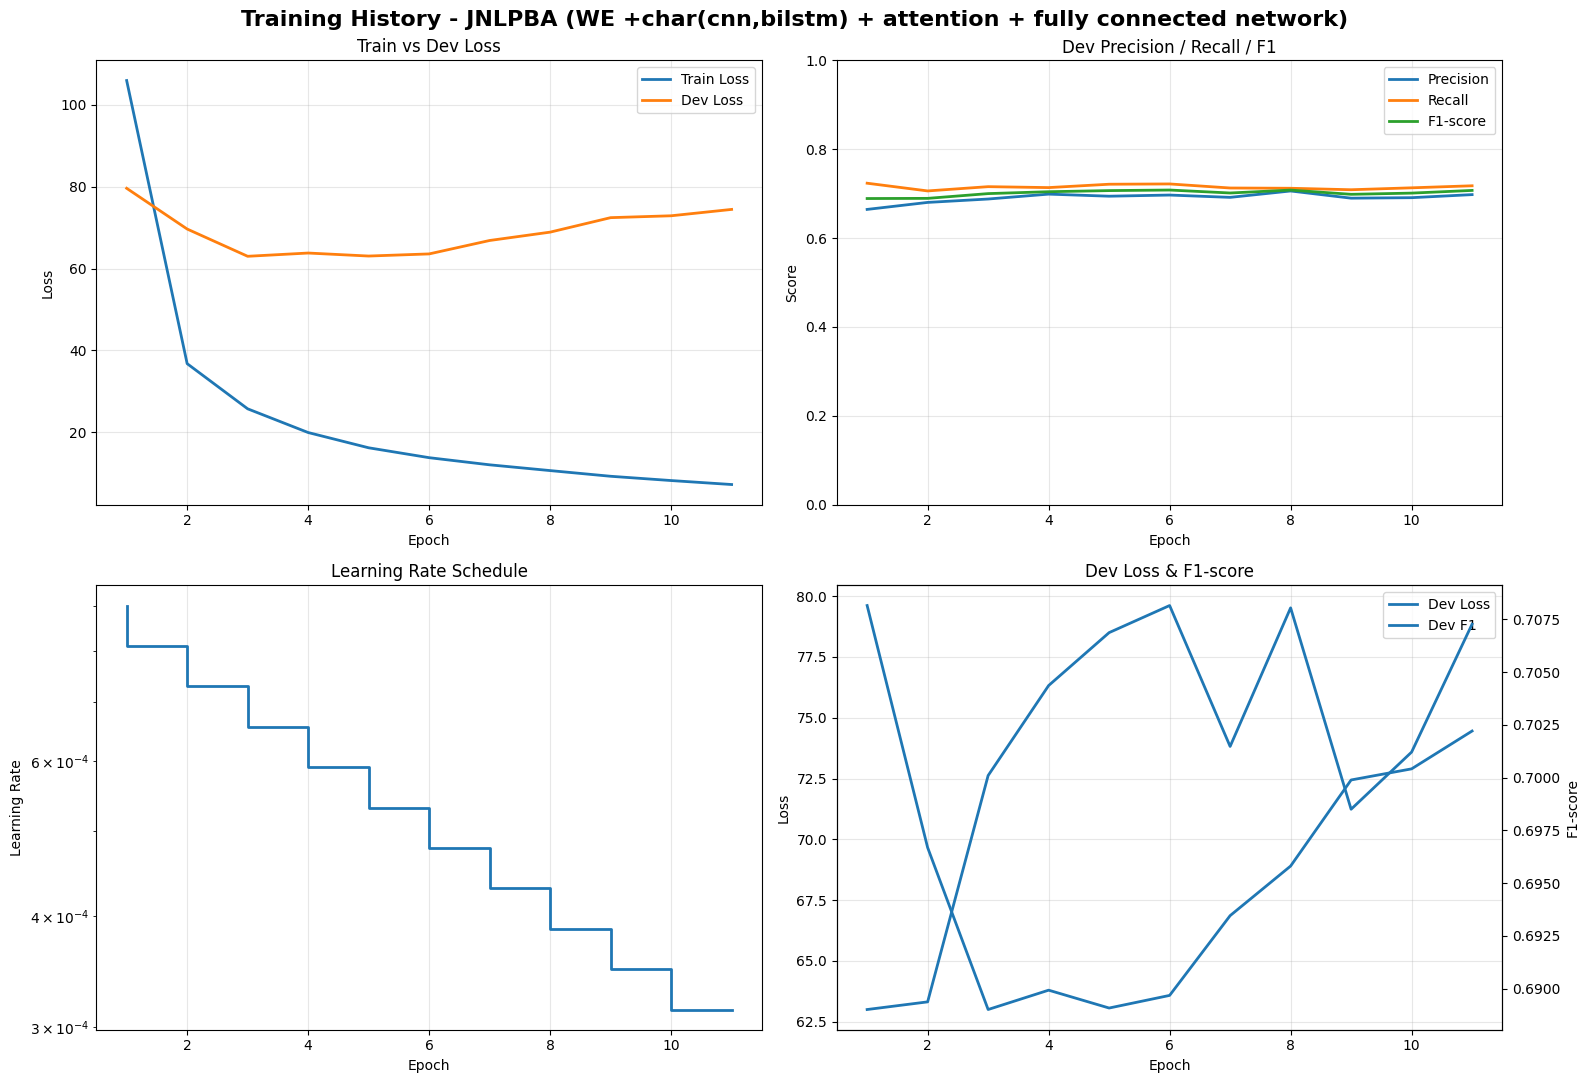


STATISTIQUES FINALES - JNLPBA (WE +char(cnn,bilstm) + attention + fully connected network)
Meilleur F1 (dev)       : 0.7081
Meilleure Precision(dev): 0.7060
Meilleur Recall (dev)   : 0.7235
Final train loss        : 7.2134
Final dev loss          : 74.4552
Final learning rate     : 0.000314


In [25]:
plot_training_history(history_we_char_cnn_bilstm_attention_fc_jnlpba, dataset_name="JNLPBA (WE +char(cnn,bilstm) + attention + fully connected network)")

In [26]:
model_path_jnlpba = "./checkpoints/JNLPBA/fastTextModel_DataAug_fullyConnectedAttention_JNLPBA.pt"
model_we_char__bilstm_cnn_attention_fc_jnlpba, device, idx_to_tag_jnlpba = load_trained_model(
    model_path=model_path_jnlpba,
    dataset_name='JNLPBA',
    loaders_dict=results_jnlpba,
    use_char_cnn=True,use_char_lstm=True,use_attention=True,use_fc_fusion=True
)
test_loader_jnlpba = results_jnlpba['test_loader']
predictions_we_char__bilstm_cnn_attention_fc_jnlpba, targets_we_char__bilstm_cnn_attention_fc_jnlpba = predict_on_test_set(
    model=model_we_char__bilstm_cnn_attention_fc_jnlpba,
    test_loader=test_loader_jnlpba,
    device=device,
    idx_to_tag=idx_to_tag_jnlpba
)

Modèle chargé depuis: ./checkpoints/JNLPBA/fastTextModel_DataAug_fullyConnectedAttention_JNLPBA.pt
Best F1 enregistré: 0.7081
Époque: 5
  0 -> <PAD>
  1 -> B-DNA
  2 -> B-RNA
  3 -> B-cell_line
  4 -> B-cell_type
  5 -> B-protein
  6 -> I-DNA
  7 -> I-RNA
  8 -> I-cell_line
  9 -> I-cell_type
  10 -> I-protein
  11 -> O
  0 | O                  | O                  correct
  1 | O                  | O                  correct
  2 | O                  | O                  correct
  3 | O                  | O                  correct
  4 | O                  | O                  correct
  5 | O                  | O                  correct
  6 | O                  | O                  correct
  7 | B-protein          | B-protein          correct
  8 | O                  | O                  correct
  9 | O                  | O                  correct
 10 | O                  | O                  correct
 11 | O                  | O                  correct
 12 | O                  | O  

C:\Users\oumak\AppData\Local\Temp\ipykernel_17592\797274475.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)



Accuracy globale: 0.9325

📊 ÉVALUATION NER — JNLPBA
✓ Tokens totaux         : 88,214
✓ Tokens entités (non-O): 19,175

──────────────────────────────────────────────────
✅ ÉVALUATION AVEC 'O' (tous les tokens)
──────────────────────────────────────────────────
  Accuracy (tous tokens)    : 0.9325
  F1 Macro                 : 0.8036
  F1 Weighted              : 0.9327

──────────────────────────────────────────────────
✅ ÉVALUATION SANS 'O' (entités uniquement)
──────────────────────────────────────────────────
  Accuracy (tokens entités) : 0.8053
  F1 Macro                  : 0.7621
  F1 Weighted               : 0.8489


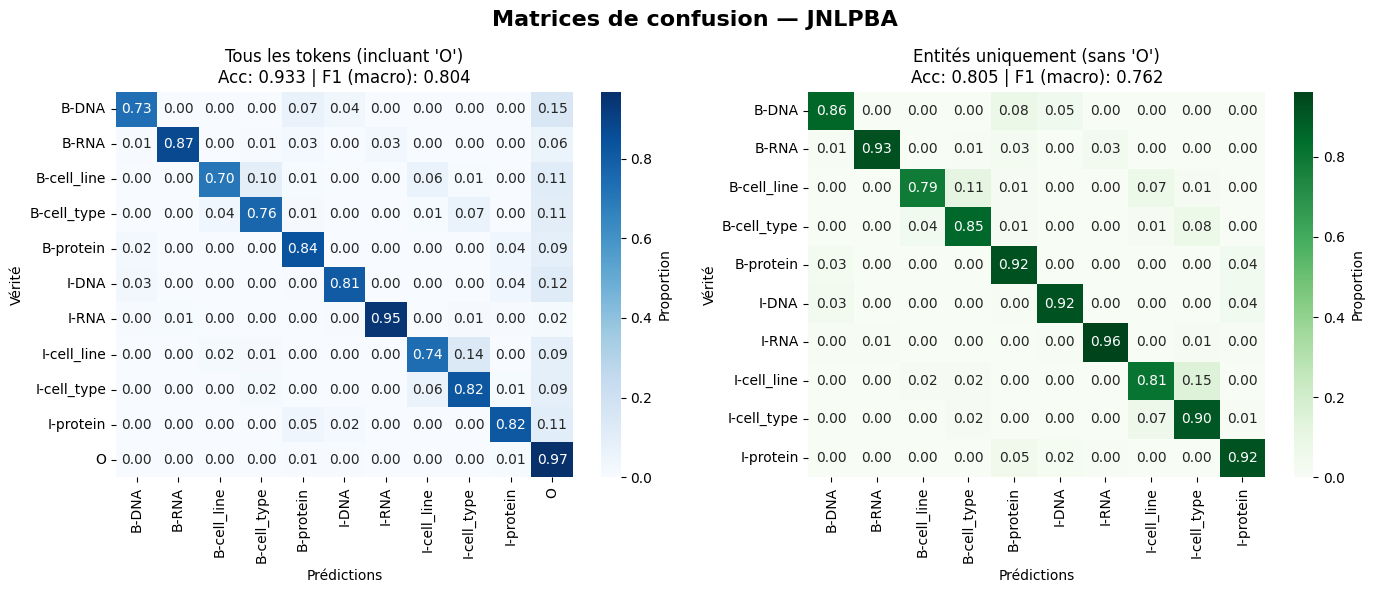


📊 Métriques par classe (AVEC 'O')
────────────────────────────────────────────────────────────
Classe               Précision  Rappel     F1         Support 
────────────────────────────────────────────────────────────
B-DNA                0.7411     0.7320     0.7365     1623    
B-RNA                0.7340     0.8734     0.7977     158     
B-cell_line          0.7724     0.6996     0.7342     689     
B-cell_type          0.7485     0.7642     0.7563     1285    
B-protein            0.8345     0.8409     0.8377     5134    
I-DNA                0.8111     0.8081     0.8096     2689    
I-RNA                0.7667     0.9452     0.8466     219     
I-cell_line          0.7506     0.7373     0.7439     1237    
I-cell_type          0.7646     0.8239     0.7932     1806    
I-protein            0.8081     0.8198     0.8139     4335    
O                    0.9712     0.9679     0.9695     69039   

📊 Métriques par classe (SANS 'O')
────────────────────────────────────────────────────

In [27]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char__bilstm_cnn_attention_fc_jnlpba, predictions_we_char__bilstm_cnn_attention_fc_jnlpba)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_char__bilstm_cnn_attention_fc_jnlpba, targets_we_char__bilstm_cnn_attention_fc_jnlpba) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_char__bilstm_cnn_attention_fc_jnlpba, targets_we_char__bilstm_cnn_attention_fc_jnlpba) if t != 'O']

if set(predictions_we_char__bilstm_cnn_attention_fc_jnlpba) == set(targets_we_char__bilstm_cnn_attention_fc_jnlpba) or all(isinstance(p, str) for p in predictions_we_char__bilstm_cnn_attention_fc_jnlpba):
    jnlpba_metrics  = plot_confusion_matrix_by_class(
    predictions_we_char__bilstm_cnn_attention_fc_jnlpba,
    targets_we_char__bilstm_cnn_attention_fc_jnlpba,
    idx_to_tag_jnlpba,
    dataset_name="JNLPBA"
)
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char__bilstm_cnn_attention_fc_jnlpba[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char__bilstm_cnn_attention_fc_jnlpba[:10])}")

### Test sur un nombre d'exemples :

In [ ]:
import torch

# ─────────────────────────────────────────────
# 1. Chargement checkpoint
#─────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"

checkpoint_path = "./checkpoints/JNLPBA/fastTextModel_DataAug_fullyConnectedAttention_JNLPBA.pt"
ckpt = torch.load(checkpoint_path, map_location=device)

# ─────────────────────────────────────────────
# 2. Récupération EXACTE des objets du training
# ─────────────────────────────────────────────
# Ces objets doivent venir des loaders utilisés à l'entraînement
train_loader = results_jnlpba["train_loader"]
vocab        = results_jnlpba["vocab"]
char_vocab   = results_jnlpba["char_vocab"]
tag_to_idx   = results_jnlpba["tag_to_idx"]
idx_to_tag   = results_jnlpba["idx_to_tag"]

# ─────────────────────────────────────────────
# 3. Reconstruction du modèle (IDENTIQUE au training)
# ─────────────────────────────────────────────
model = CombinatorialNER(
    vocab_size=len(vocab),
    char_vocab_size=len(char_vocab),
    tag_to_idx=tag_to_idx,
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=True,
    pretrained_embeddings=results_jnlpba["pretrained_embeddings"],
    word_embed_dim=200,
    lstm_hidden_dim=256,
    dropout=0.5
).to(device)

model.load_state_dict(ckpt["model_state_dict"])
model.eval()

def token_accuracy(all_preds, all_golds):
    correct = 0
    total = 0
    for preds, golds in zip(all_preds, all_golds):
        for p, g in zip(preds, golds):
            if g != "<PAD>":
                total += 1
                if p == g:
                    correct += 1
    return correct / total

def token_accuracy_single(preds, golds):
    correct = 0
    total = 0
    for p, g in zip(preds, golds):
        if g != "<PAD>":
            total += 1
            if p == g:
                correct += 1
    return correct / total if total > 0 else 0.0


# ─────────────────────────────────────────────
# 4. Fonction de prédiction CORRECTE
# ─────────────────────────────────────────────
def predict_sentence(
    model,
    sentence,
    vocab,
    char_vocab,
    idx_to_tag,
    device,
    max_seq_len=100,
    max_char_len=20
):
    model.eval()

    PAD_WORD = vocab["<PAD>"]
    UNK_WORD = vocab["<UNK>"]
    PAD_CHAR = char_vocab["<PAD>"]
    UNK_CHAR = char_vocab["<UNK>"]

    # 1. Troncature
    tokens = sentence[:max_seq_len]
    seq_len = len(tokens)

    # 2. Word IDs
    word_ids = [vocab.get(w.lower(), UNK_WORD) for w in tokens]
    word_ids += [PAD_WORD] * (max_seq_len - seq_len)

    # 3. Char IDs
    char_seqs = []
    for w in tokens:
        chars = [char_vocab.get(c, UNK_CHAR) for c in w[:max_char_len]]
        chars += [PAD_CHAR] * (max_char_len - len(chars))
        char_seqs.append(chars)

    char_seqs += [[PAD_CHAR] * max_char_len] * (max_seq_len - seq_len)

    # 4. Tensors
    word_tensor = torch.tensor(word_ids).unsqueeze(0).to(device)
    char_tensor = torch.tensor(char_seqs).unsqueeze(0).to(device)

    mask = torch.zeros((1, max_seq_len), dtype=torch.bool).to(device)
    mask[:, :seq_len] = True

    # 5. Inference CRF
    with torch.no_grad():
        predictions = model(word_tensor, char_tensor, mask)
        predicted_ids = predictions[0][:seq_len]

    return [idx_to_tag[i] for i in predicted_ids]



# ─────────────────────────────────────────────
# 5. Phrases de test
# ─────────────────────────────────────────────
test_data = [
    # Protein + Cell line
    (
        ["Octamer-binding", "proteins", "from", "HeLa", "cells", "stimulate", "transcription"],
        ["B-protein", "I-protein", "O", "B-cell_line", "I-cell_line", "O", "O"]
    ),
    # DNA example
    (
        ["The", "BRCA1", "gene", "is", "associated", "with", "breast", "cancer"],
        ["O", "B-DNA", "O", "O", "O", "O", "B-cell_type", "O"]
    ),
    # RNA example
    (
        ["mRNA", "expression", "in", "Jurkat", "cells", "was", "upregulated"],
        ["B-RNA", "O", "O", "B-cell_line", "I-cell_line", "O", "O"]
    ),
    # Cell type example
    (
        ["T", "lymphocytes", "play", "a", "key", "role", "in", "immune", "response"],
        ["B-cell_type", "I-cell_type", "O", "O", "O", "O", "O", "O", "O"]
    ),
    # Overlapping adjacent entities
    (
        ["p53", "and", "BRCA1", "regulate", "DNA", "replication"],
        ["B-protein", "O", "B-DNA", "O", "B-DNA", "O"]
    ),
    # Mixed entities
    (
        ["The", "RNA", "of", "Jurkat", "T", "cells", "is", "similar", "to", "HeLa", "cells"],
        ["O", "B-RNA", "O", "B-cell_line", "B-cell_type", "I-cell_line", "O", "O", "O", "B-cell_line", "I-cell_line"]
    ),
    # Long sentence with multiple types
    (
        ["p53", "protein", "binds", "to", "BRCA1", "DNA", "in", "HeLa", "and", "Jurkat", "cells", "during", "transcription"],
        ["B-protein", "I-protein", "O", "O", "B-DNA", "I-DNA", "O", "B-cell_line", "O", "B-cell_line", "I-cell_line", "O", "O"]
    ),
    # DNA + RNA + protein in one sentence
    (
        ["BRCA1", "gene", "transcribes", "mRNA", "which", "produces", "p53", "protein"],
        ["B-DNA", "O", "O", "B-RNA", "O", "O", "B-protein", "I-protein"]
    ),
]

# ─────────────────────────────────────────────
# 6. Évaluation lisible
# ─────────────────────────────────────────────
all_preds = []
all_golds = []

for i, (sentence, gold) in enumerate(test_data, 1):
    preds = predict_sentence(model, sentence, vocab, char_vocab, idx_to_tag, device)

    all_preds.append(preds)
    all_golds.append(gold)

    # Accuracy par phrase
    acc_sentence = token_accuracy_single(preds, gold)

    print(f"Example {i}")
    print(f"{'Token':15s} {'Gold':15s} {'Predicted':15s}")
    print("-" * 50)
    for t, g, p in zip(sentence, gold, preds):
        print(f"{t:15s} {g:15s} {p:15s}")

    print(f"\nToken accuracy (sentence): {acc_sentence:.4f}")
    print("=" * 60 + "\n")

# Accuracy globale
acc_global = token_accuracy(all_preds, all_golds)
print(f"Global token accuracy: {acc_global:.4f}")




Example 1
Token           Gold            Predicted      
--------------------------------------------------
Octamer-binding B-protein       B-protein      
proteins        I-protein       I-protein      
from            O               O              
HeLa            B-cell_line     B-cell_line    
cells           I-cell_line     I-cell_line    
stimulate       O               O              
transcription   O               O              

Token accuracy (sentence): 1.0000

Example 2
Token           Gold            Predicted      
--------------------------------------------------
The             O               O              
BRCA1           B-DNA           B-DNA          
gene            O               I-DNA          
is              O               O              
associated      O               O              
with            O               O              
breast          B-cell_type     O              
cancer          O               O              

Token accuracy (sentence)

C:\Users\oumak\AppData\Local\Temp\ipykernel_17592\3242407666.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location=device)


## Entraînement sur NCBI Dataset

In [29]:
model_we_char_cnn_bilstm_attention_fc_ncbi, history_we_char_cnn_bilstm_attention_fc_ncbi = run_pipeline(
    dataset_name='NCBI',
    loaders=results_ncbi,
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=True,
    embedding_url=None,  
    lstm_hidden_dim=128,
    epochs=100,
    patience=5,
    checkpoints_dir="./checkpoints/NCBI"
)

Model parameters: 2,203,068


Training: 100%|██████████| 70/70 [00:17<00:00,  3.96it/s]


Epoch 01/100 | Train loss: 1944.5900 | Dev loss: 1567.0117 | P: 0.2593 R: 0.0068 F1: 0.0132 | LR: 0.000950
Meilleur modèle sauvegardé: F1 0.0132


Training: 100%|██████████| 70/70 [00:16<00:00,  4.20it/s]


Epoch 02/100 | Train loss: 1102.6029 | Dev loss: 894.5752 | P: 0.5059 R: 0.3282 F1: 0.3862 | LR: 0.000902
Meilleur modèle sauvegardé: F1 0.3862


Training: 100%|██████████| 70/70 [00:16<00:00,  4.22it/s]


Epoch 03/100 | Train loss: 594.2235 | Dev loss: 691.1137 | P: 0.5176 R: 0.4526 F1: 0.4813 | LR: 0.000857
Meilleur modèle sauvegardé: F1 0.4813


Training: 100%|██████████| 70/70 [00:16<00:00,  4.29it/s]


Epoch 04/100 | Train loss: 433.5756 | Dev loss: 682.7579 | P: 0.5355 R: 0.4806 F1: 0.5065 | LR: 0.000815
Meilleur modèle sauvegardé: F1 0.5065


Training: 100%|██████████| 70/70 [00:16<00:00,  4.29it/s]


Epoch 05/100 | Train loss: 334.5964 | Dev loss: 676.6051 | P: 0.5519 R: 0.4907 F1: 0.5194 | LR: 0.000774
Meilleur modèle sauvegardé: F1 0.5194


Training: 100%|██████████| 70/70 [00:16<00:00,  4.31it/s]


Epoch 06/100 | Train loss: 287.6779 | Dev loss: 653.8773 | P: 0.5589 R: 0.5149 F1: 0.5359 | LR: 0.000735
Meilleur modèle sauvegardé: F1 0.5359


Training: 100%|██████████| 70/70 [00:16<00:00,  4.29it/s]


Epoch 07/100 | Train loss: 245.8961 | Dev loss: 660.7080 | P: 0.5601 R: 0.5261 F1: 0.5422 | LR: 0.000698
Meilleur modèle sauvegardé: F1 0.5422


Training: 100%|██████████| 70/70 [00:16<00:00,  4.29it/s]


Epoch 08/100 | Train loss: 222.0339 | Dev loss: 668.6595 | P: 0.5650 R: 0.5250 F1: 0.5436 | LR: 0.000663
Meilleur modèle sauvegardé: F1 0.5436


Training: 100%|██████████| 70/70 [00:17<00:00,  4.04it/s]


Epoch 09/100 | Train loss: 192.0410 | Dev loss: 701.5184 | P: 0.5572 R: 0.5366 F1: 0.5459 | LR: 0.000630
Meilleur modèle sauvegardé: F1 0.5459


Training: 100%|██████████| 70/70 [00:17<00:00,  4.02it/s]


Epoch 10/100 | Train loss: 175.9884 | Dev loss: 717.1951 | P: 0.5651 R: 0.5244 F1: 0.5439 | LR: 0.000599


Training: 100%|██████████| 70/70 [00:17<00:00,  4.03it/s]


Epoch 11/100 | Train loss: 158.6556 | Dev loss: 715.3891 | P: 0.5577 R: 0.5347 F1: 0.5455 | LR: 0.000569


Training: 100%|██████████| 70/70 [00:17<00:00,  3.98it/s]


Epoch 12/100 | Train loss: 146.1666 | Dev loss: 738.2799 | P: 0.5713 R: 0.5244 F1: 0.5466 | LR: 0.000540
Meilleur modèle sauvegardé: F1 0.5466


Training: 100%|██████████| 70/70 [00:17<00:00,  3.99it/s]


Epoch 13/100 | Train loss: 132.3067 | Dev loss: 748.4950 | P: 0.5784 R: 0.5218 F1: 0.5482 | LR: 0.000513
Meilleur modèle sauvegardé: F1 0.5482


Training: 100%|██████████| 70/70 [00:17<00:00,  3.98it/s]


Epoch 14/100 | Train loss: 125.0012 | Dev loss: 692.0868 | P: 0.5689 R: 0.5398 F1: 0.5538 | LR: 0.000488
Meilleur modèle sauvegardé: F1 0.5538


Training: 100%|██████████| 70/70 [00:16<00:00,  4.17it/s]


Epoch 15/100 | Train loss: 113.2128 | Dev loss: 809.4450 | P: 0.5831 R: 0.5210 F1: 0.5501 | LR: 0.000463


Training: 100%|██████████| 70/70 [00:16<00:00,  4.22it/s]


Epoch 16/100 | Train loss: 106.5994 | Dev loss: 837.3860 | P: 0.5831 R: 0.5165 F1: 0.5476 | LR: 0.000440


Training: 100%|██████████| 70/70 [00:16<00:00,  4.29it/s]


Epoch 17/100 | Train loss: 98.3662 | Dev loss: 827.2747 | P: 0.5821 R: 0.5216 F1: 0.5499 | LR: 0.000418


Training: 100%|██████████| 70/70 [00:16<00:00,  4.31it/s]


Epoch 18/100 | Train loss: 99.8935 | Dev loss: 789.6422 | P: 0.5767 R: 0.5254 F1: 0.5495 | LR: 0.000397


Training: 100%|██████████| 70/70 [00:16<00:00,  4.32it/s]


Epoch 19/100 | Train loss: 90.4932 | Dev loss: 803.1227 | P: 0.5766 R: 0.5241 F1: 0.5487 | LR: 0.000377
Early stopping triggered après 19 epochs.


C:\Users\oumak\AppData\Local\Temp\ipykernel_17592\3464221916.py:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoints_path)



RÉSULTATS FINAUX SUR LE TEST SET
Loss: 829.9473
Precision: 0.5590
Recall: 0.5262
F1-score: 0.5420


In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history, dataset_name):
    """
    Visualise l'historique d'entraînement avec Loss, F1, Precision, Recall
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 11))
    fig.suptitle(f'Training History - {dataset_name}', fontsize=16, fontweight='bold')

    epochs = range(1, len(history['train_loss']) + 1)

    # ─────────────────────────────────────────────
    # Plot 1: Train vs Dev Loss
    # ─────────────────────────────────────────────
    axes[0, 0].plot(epochs, history['train_loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['dev_loss'], label='Dev Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Train vs Dev Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # ─────────────────────────────────────────────
    # Plot 2: Dev Precision / Recall / F1
    # ─────────────────────────────────────────────
    axes[0, 1].plot(epochs, history['dev_precision'], label='Precision', linewidth=2)
    axes[0, 1].plot(epochs, history['dev_recall'], label='Recall', linewidth=2)
    axes[0, 1].plot(epochs, history['dev_f1'], label='F1-score', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].set_title('Dev Precision / Recall / F1')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # ─────────────────────────────────────────────
    # Plot 3: Learning Rate
    # ─────────────────────────────────────────────
    axes[1, 0].step(epochs, history['lr'], linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].grid(True, alpha=0.3)

    # ─────────────────────────────────────────────
    # Plot 4: Dev Loss vs F1
    # ─────────────────────────────────────────────
    ax_loss = axes[1, 1]
    ax_f1 = ax_loss.twinx()

    line1, = ax_loss.plot(epochs, history['dev_loss'], label='Dev Loss', linewidth=2)
    line2, = ax_f1.plot(epochs, history['dev_f1'], label='Dev F1', linewidth=2)

    ax_loss.set_xlabel('Epoch')
    ax_loss.set_ylabel('Loss')
    ax_f1.set_ylabel('F1-score')
    ax_loss.set_title('Dev Loss & F1-score')

    lines = [line1, line2]
    labels = [l.get_label() for l in lines]
    ax_loss.legend(lines, labels, loc='upper right')

    ax_loss.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # ─────────────────────────────────────────────
    # Résumé numérique final
    # ─────────────────────────────────────────────
    print(f"\nSTATISTIQUES FINALES - {dataset_name}")
    print(f"Meilleur F1 (dev)       : {max(history['dev_f1']):.4f}")
    print(f"Meilleure Precision(dev): {max(history['dev_precision']):.4f}")
    print(f"Meilleur Recall (dev)   : {max(history['dev_recall']):.4f}")
    print(f"Final train loss        : {history['train_loss'][-1]:.4f}")
    print(f"Final dev loss          : {history['dev_loss'][-1]:.4f}")
    print(f"Final learning rate     : {history['lr'][-1]:.6f}")


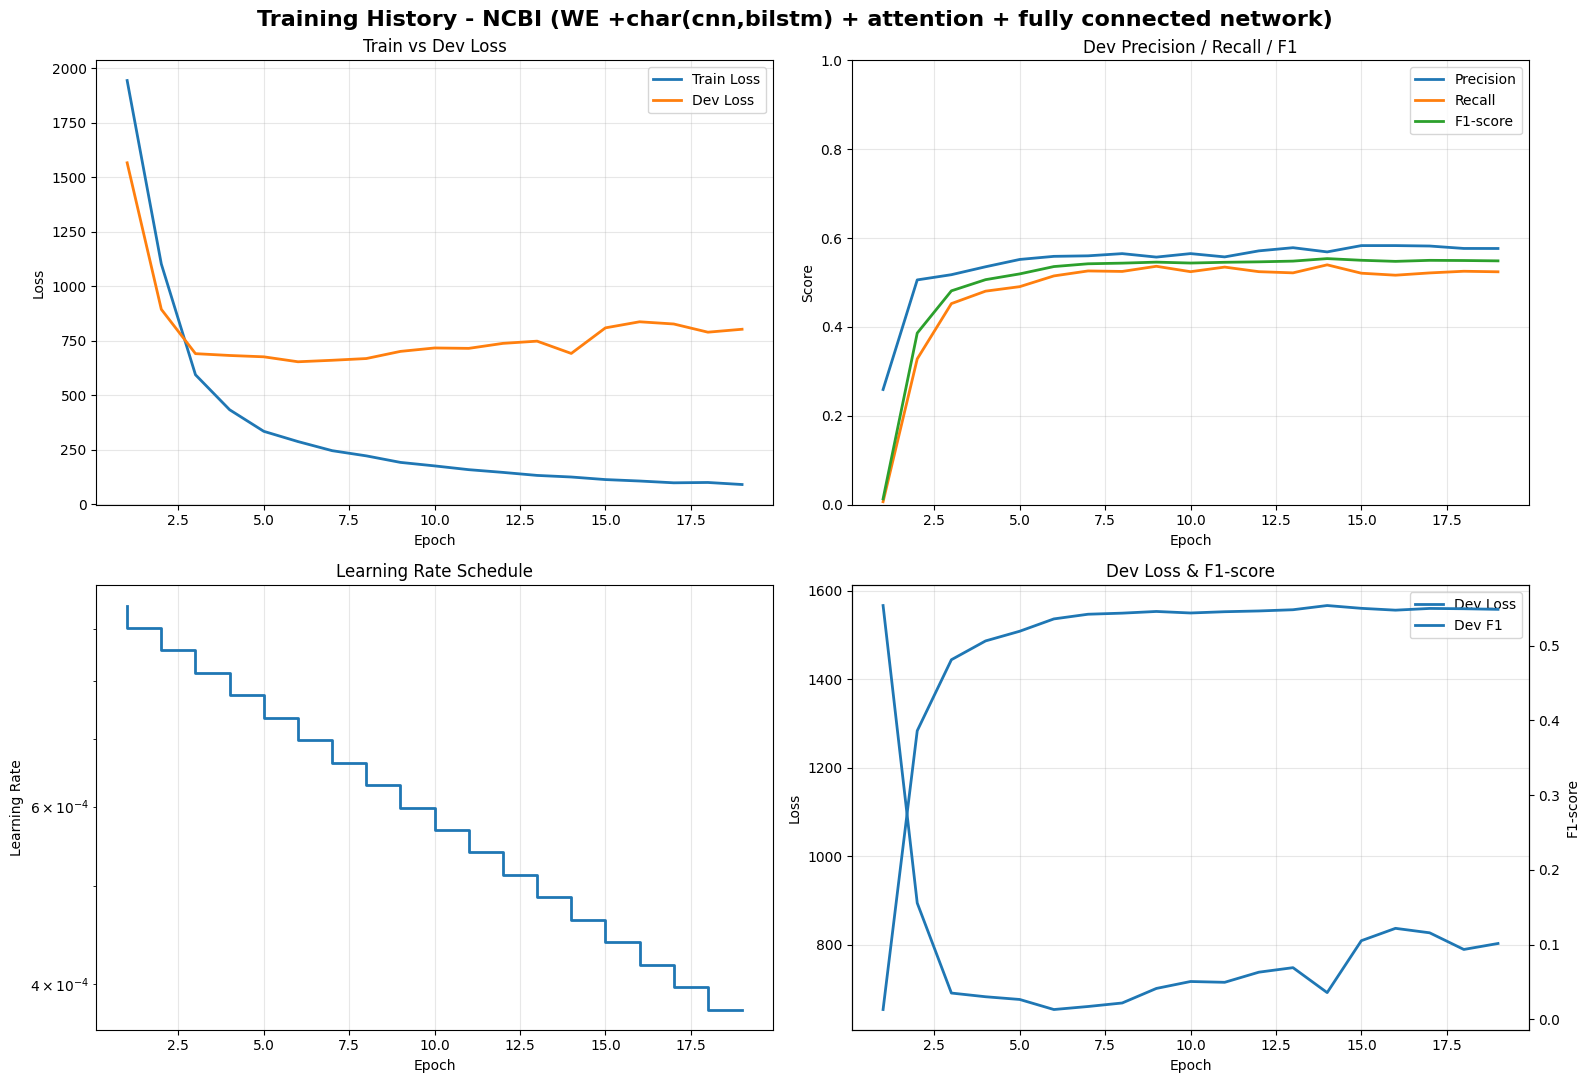


STATISTIQUES FINALES - NCBI (WE +char(cnn,bilstm) + attention + fully connected network)
Meilleur F1 (dev)       : 0.5538
Meilleure Precision(dev): 0.5831
Meilleur Recall (dev)   : 0.5398
Final train loss        : 90.4932
Final dev loss          : 803.1227
Final learning rate     : 0.000377


In [31]:
plot_training_history(history_we_char_cnn_bilstm_attention_fc_ncbi, dataset_name="NCBI (WE +char(cnn,bilstm) + attention + fully connected network)")

In [32]:
model_path_ncbi = "./checkpoints/NCBI/fastTextModel_DataAug_fullyConnectedAttention_NCBI.pt"
model_we_char_cnn_bilstm_attention_fc_ncbi, device, idx_to_tag_ncbi = load_trained_model(
    model_path=model_path_ncbi,
    dataset_name='NCBI',
    loaders_dict=results_ncbi,
    use_char_cnn=True,use_char_lstm=True,use_attention=True,use_fc_fusion=True
)

test_loader_ncbi = results_ncbi['test_loader']
predictions_we_char__bilstm_cnn_attention_fc_ncbi, targets_we_char__bilstm_cnn_attention_fc_ncbi = predict_on_test_set(
    model=model_we_char_cnn_bilstm_attention_fc_ncbi,
    test_loader=test_loader_ncbi,
    device=device,
    idx_to_tag=idx_to_tag_ncbi
)

Modèle chargé depuis: ./checkpoints/NCBI/fastTextModel_DataAug_fullyConnectedAttention_NCBI.pt
Best F1 enregistré: 0.5538
Époque: 13
  0 -> <PAD>
  1 -> B-Disease
  2 -> I-Disease
  3 -> O
  0 | O                  | O                  correct
  1 | B-Disease          | B-Disease          correct
  2 | I-Disease          | I-Disease          correct
  3 | I-Disease          | I-Disease          correct
  4 | I-Disease          | I-Disease          correct
  5 | I-Disease          | I-Disease          correct
  6 | I-Disease          | I-Disease          correct
  7 | I-Disease          | I-Disease          correct
  8 | I-Disease          | I-Disease          correct
  9 | I-Disease          | I-Disease          correct
 10 | I-Disease          | I-Disease          correct
 11 | O                  | O                  correct
 12 | O                  | O                  correct
 13 | O                  | O                  correct
 14 | O                  | O                  correct
 

C:\Users\oumak\AppData\Local\Temp\ipykernel_17592\797274475.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)



Accuracy globale: 0.9191

📊 ÉVALUATION NER — NCBI Disease
✓ Tokens totaux         : 21,211
✓ Tokens entités (non-O): 5,933

──────────────────────────────────────────────────
✅ ÉVALUATION AVEC 'O' (tous les tokens)
──────────────────────────────────────────────────
  Accuracy (tous tokens)    : 0.9191
  F1 Macro                 : 0.8587
  F1 Weighted              : 0.9184

──────────────────────────────────────────────────
✅ ÉVALUATION SANS 'O' (entités uniquement)
──────────────────────────────────────────────────
  Accuracy (tokens entités) : 0.8197
  F1 Macro                  : 0.5700
  F1 Weighted               : 0.8861


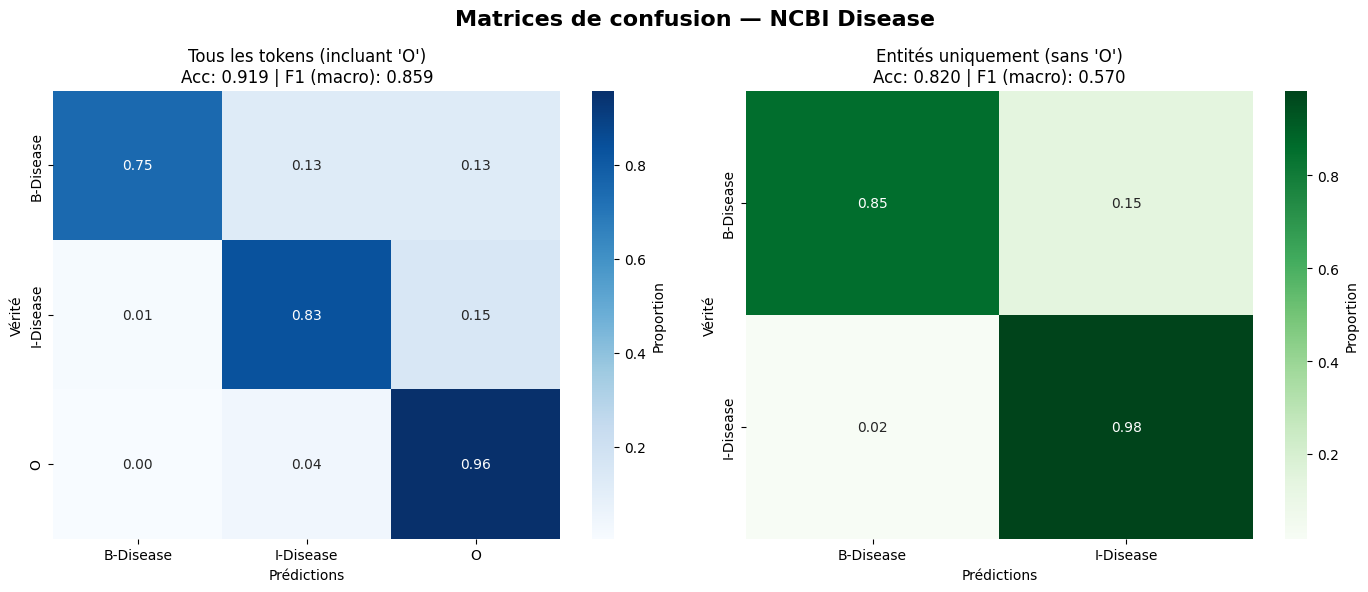


📊 Métriques par classe (AVEC 'O')
────────────────────────────────────────────────────────────
Classe               Précision  Rappel     F1         Support 
────────────────────────────────────────────────────────────
B-Disease            0.8160     0.7473     0.7801     819     
I-Disease            0.8609     0.8312     0.8458     5114    
O                    0.9427     0.9578     0.9502     15278   

📊 Métriques par classe (SANS 'O')
────────────────────────────────────────────────────────────
Classe               Précision  Rappel     F1         Support 
────────────────────────────────────────────────────────────
B-Disease            0.8895     0.7473     0.8122     819     
I-Disease            0.9761     0.8312     0.8979     5114    


In [33]:
# Pour tous les tokens (y compris 'O')
accuracy = accuracy_score(targets_we_char__bilstm_cnn_attention_fc_ncbi, predictions_we_char__bilstm_cnn_attention_fc_ncbi)
print(f"\nAccuracy globale: {accuracy:.4f}")

entity_preds = [p for p, t in zip(predictions_we_char__bilstm_cnn_attention_fc_ncbi, targets_we_char__bilstm_cnn_attention_fc_ncbi) if t != 'O']
entity_targets = [t for p, t in zip(predictions_we_char__bilstm_cnn_attention_fc_ncbi, targets_we_char__bilstm_cnn_attention_fc_ncbi) if t != 'O']

if set(predictions_we_char__bilstm_cnn_attention_fc_ncbi) == set(targets_we_char__bilstm_cnn_attention_fc_ncbi) or all(isinstance(p, str) for p in predictions_we_char__bilstm_cnn_attention_fc_ncbi):
    ncbi_metrics  = plot_confusion_matrix_by_class(
    predictions_we_char__bilstm_cnn_attention_fc_ncbi,
    targets_we_char__bilstm_cnn_attention_fc_ncbi,
    idx_to_tag_ncbi,
    dataset_name="NCBI Disease"
)
    
else:
    print("\nERREUR: Les prédictions et cibles n'ont pas les mêmes types!")
    print(f"Types prédictions: {set(type(p) for p in predictions_we_char__bilstm_cnn_attention_fc_ncbi[:10])}")
    print(f"Types cibles: {set(type(t) for t in targets_we_char__bilstm_cnn_attention_fc_ncbi[:10])}")

### Test on a set of examples

In [ ]:
# ─────────────────────────────────────────────
# 1. Chargement checkpoint
# ─────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"

checkpoint_path = "./checkpoints/NCBI/fastTextModel_DataAug_fullyConnectedAttention_NCBI.pt"
ckpt = torch.load(checkpoint_path, map_location=device)

# ─────────────────────────────────────────────
# 2. Récupération EXACTE des objets du training
# ─────────────────────────────────────────────
# Ces objets doivent venir des loaders utilisés à l'entraînement
train_loader = results_ncbi["train_loader"]
vocab        = results_ncbi["vocab"]
char_vocab   = results_ncbi["char_vocab"]
tag_to_idx   = results_ncbi["tag_to_idx"]
idx_to_tag   = results_ncbi["idx_to_tag"]

# ─────────────────────────────────────────────
# 3. Reconstruction du modèle (IDENTIQUE au training)
# ─────────────────────────────────────────────
model = CombinatorialNER(
    dataset="NCBI",
    vocab_size=len(vocab),
    char_vocab_size=len(char_vocab),
    tag_to_idx=tag_to_idx,
    use_char_cnn=True,
    use_char_lstm=True,
    use_attention=True,
    use_fc_fusion=True,
    pretrained_embeddings=results_ncbi["pretrained_embeddings"],
    word_embed_dim=200,
    lstm_hidden_dim=128,   # JNLPBA
    dropout=0.5
).to(device)

model.load_state_dict(ckpt["model_state_dict"])
model.eval()

def token_accuracy(all_preds, all_golds):
    correct = 0
    total = 0
    for preds, golds in zip(all_preds, all_golds):
        for p, g in zip(preds, golds):
            if g != "<PAD>":
                total += 1
                if p == g:
                    correct += 1
    return correct / total

def token_accuracy_single(preds, golds):
    correct = 0
    total = 0
    for p, g in zip(preds, golds):
        if g != "<PAD>":
            total += 1
            if p == g:
                correct += 1
    return correct / total if total > 0 else 0.0


# ─────────────────────────────────────────────
# 4. Fonction de prédiction CORRECTE
# ─────────────────────────────────────────────
def predict_sentence(
    model,
    sentence,
    vocab,
    char_vocab,
    idx_to_tag,
    device,
    max_seq_len=100,
    max_char_len=20
):
    model.eval()

    PAD_WORD = vocab["<PAD>"]
    UNK_WORD = vocab["<UNK>"]
    PAD_CHAR = char_vocab["<PAD>"]
    UNK_CHAR = char_vocab["<UNK>"]

    # 1. Troncature
    tokens = sentence[:max_seq_len]
    seq_len = len(tokens)

    # 2. Word IDs
    word_ids = [vocab.get(w.lower(), UNK_WORD) for w in tokens]
    word_ids += [PAD_WORD] * (max_seq_len - seq_len)

    # 3. Char IDs
    char_seqs = []
    for w in tokens:
        chars = [char_vocab.get(c, UNK_CHAR) for c in w[:max_char_len]]
        chars += [PAD_CHAR] * (max_char_len - len(chars))
        char_seqs.append(chars)

    char_seqs += [[PAD_CHAR] * max_char_len] * (max_seq_len - seq_len)

    # 4. Tensors
    word_tensor = torch.tensor(word_ids).unsqueeze(0).to(device)
    char_tensor = torch.tensor(char_seqs).unsqueeze(0).to(device)

    mask = torch.zeros((1, max_seq_len), dtype=torch.bool).to(device)
    mask[:, :seq_len] = True

    # 5. Inference CRF
    with torch.no_grad():
        predictions = model(word_tensor, char_tensor, mask)
        predicted_ids = predictions[0][:seq_len]

    return [idx_to_tag[i] for i in predicted_ids]



test_data = [
    # Exemple 1
    (["the", "hereditary", "breast", "and", "ovarian", "cancer", "syndrome", "is", "associated", "with", "a", "high", "frequency", "of", "brca1", "mutations", "."],
     ["O", "B-Disease", "I-Disease", "I-Disease", "I-Disease", "I-Disease", "I-Disease", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O"]),

    # Exemple 2
    (["patients", "with", "BRCA1", "mutation", "show", "increased", "risk"],
     ["O", "O", "B-Disease", "I-Disease", "O", "O", "O"]),

    # Exemple 3
    (["the", "prevalence", "of", "hereditary", "breast", "cancer", "is", "high", "in", "certain", "populations"],
     ["O", "O", "O", "B-Disease", "I-Disease", "I-Disease", "O", "O", "O", "O", "O"])
]




# ─────────────────────────────────────────────
# 6. Évaluation lisible
# ─────────────────────────────────────────────
all_preds = []
all_golds = []

for i, (sentence, gold) in enumerate(test_data, 1):
    preds = predict_sentence(model, sentence, vocab, char_vocab, idx_to_tag, device)

    all_preds.append(preds)
    all_golds.append(gold)

    # Accuracy par phrase
    acc_sentence = token_accuracy_single(preds, gold)

    print(f"Example {i}")
    print(f"{'Token':15s} {'Gold':15s} {'Predicted':15s}")
    print("-" * 50)
    for t, g, p in zip(sentence, gold, preds):
        print(f"{t:15s} {g:15s} {p:15s}")

    print(f"\nToken accuracy (sentence): {acc_sentence:.4f}")
    print("=" * 60 + "\n")

# Accuracy globale
acc_global = token_accuracy(all_preds, all_golds)
print(f"Global token accuracy: {acc_global:.4f}")

Example 1
Token           Gold            Predicted      
--------------------------------------------------
the             O               O              
hereditary      B-Disease       B-Disease      
breast          I-Disease       I-Disease      
and             I-Disease       I-Disease      
ovarian         I-Disease       I-Disease      
cancer          I-Disease       I-Disease      
syndrome        I-Disease       I-Disease      
is              O               I-Disease      
associated      O               I-Disease      
with            O               I-Disease      
a               O               I-Disease      
high            O               I-Disease      
frequency       O               I-Disease      
of              O               I-Disease      
brca1           O               O              
mutations       O               O              
.               O               O              

Token accuracy (sentence): 0.5882

Example 2
Token           Gold         

C:\Users\oumak\AppData\Local\Temp\ipykernel_17592\3177499904.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(checkpoint_path, map_location=device)
